In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/electric-vehicle-specifications-dataset-2025/electric_vehicles_spec_2025.csv.csv


*imports*

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from tabulate import tabulate

In [4]:
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd

df = pd.read_csv('/kaggle/input/electric-vehicle-specifications-dataset-2025/electric_vehicles_spec_2025.csv.csv')
df.head()


brand                model  top_speed_kmh  battery_capacity_kWh  \
0  Abarth     500e Convertible            155                  37.8   
1  Abarth       500e Hatchback            155                  37.8   
2  Abarth  600e Scorpionissima            200                  50.8   
3  Abarth         600e Turismo            200                  50.8   
4  Aiways                   U5            150                  60.0   

  battery_type  number_of_cells  torque_nm  efficiency_wh_per_km  range_km  \
0  Lithium-ion            192.0      235.0                   156       225   
1  Lithium-ion            192.0      235.0                   149       225   
2  Lithium-ion            102.0      345.0                   158       280   
3  Lithium-ion            102.0      345.0                   158       280   
4  Lithium-ion              NaN      310.0                   156       315   

   acceleration_0_100_s  ...  towing_capacity_kg cargo_volume_l  seats  \
0                   7.0  ...                 0.0            185      4   
1                   7.0  ...                 0.0            185      4   
2                   5.9  ...                 0.0            360      5   
3                   6.2  ...                 0.0            360      5   
4                   7.5  ...                 NaN            496      5   

  drivetrain       segment length_mm width_mm  height_mm  car_body_type  \
0        FWD   B - Compact      3673     1683       1518      Hatchback   
1        FWD   B - Compact      3673     1683       1518      Hatchback   
2        FWD  JB - Compact      4187     1779       1557            SUV   
3        FWD  JB - Compact      4187     1779       1557            SUV   
4        FWD   JC - Medium      4680     1865       1700            SUV   

                                          source_url  
0  https://ev-database.org/car/1904/Abarth-500e-C...  
1  https://ev-database.org/car/1903/Abarth-500e-H...  
2  https://ev-database.org/car/3057/Abarth-600e-S...  
3  https://ev-database.org/car/3056/Abarth-600e-T...  
4         https://ev-database.org/car/1678/Aiways-U5  

[5 rows x 22 columns]

In [6]:
import pandas as pd

# Load the dataset
df = pd.read_csv('/kaggle/input/electric-vehicle-specifications-dataset-2025/electric_vehicles_spec_2025.csv.csv')

# Basic Info
print("Shape:", df.shape)                   # Rows and columns
print("Columns:", df.columns.tolist())      # List of columns
df.info()                                   # Data types and non-null counts
df.describe(include='all')                  # Summary statistics (numeric & categorical)

# Display first & last rows
display(df.head())
display(df.tail())

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Drop duplicate rows if any
df = df.drop_duplicates()

# Standardize column names (optional cleanup)
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace(r'[^\w]', '', regex=True)

# Check unique values per column (especially for categorical analysis)
for col in df.columns:
    print(f"\nUnique values in '{col}':", df[col].nunique())

# Correlation matrix for numeric columns
print("\nCorrelation matrix:")
print(df.corr(numeric_only=True))

# Value counts for categorical fields (if they exist)
categorical_cols = df.select_dtypes(include='object').columns
for col in categorical_cols:
    print(f"\nValue counts for '{col}':")
    print(df[col].value_counts().head())

# Example of filtering: EVs with top range
if 'range_km' in df.columns:
    top_range_vehicles = df.sort_values(by='range_km', ascending=False).head(10)
    print("\nTop 10 electric vehicles by range:")
    display(top_range_vehicles)

# Save cleaned version (optional)
# df.to_csv("cleaned_ev_dataset.csv", index=False)


Shape: (478, 22)
Columns: ['brand', 'model', 'top_speed_kmh', 'battery_capacity_kWh', 'battery_type', 'number_of_cells', 'torque_nm', 'efficiency_wh_per_km', 'range_km', 'acceleration_0_100_s', 'fast_charging_power_kw_dc', 'fast_charge_port', 'towing_capacity_kg', 'cargo_volume_l', 'seats', 'drivetrain', 'segment', 'length_mm', 'width_mm', 'height_mm', 'car_body_type', 'source_url']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 478 entries, 0 to 477
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   brand                      478 non-null    object 
 1   model                      477 non-null    object 
 2   top_speed_kmh              478 non-null    int64  
 3   battery_capacity_kWh       478 non-null    float64
 4   battery_type               478 non-null    object 
 5   number_of_cells            276 non-null    float64
 6   torque_nm                  471 non-null    float64
 7   

brand                model  top_speed_kmh  battery_capacity_kWh  \
0  Abarth     500e Convertible            155                  37.8   
1  Abarth       500e Hatchback            155                  37.8   
2  Abarth  600e Scorpionissima            200                  50.8   
3  Abarth         600e Turismo            200                  50.8   
4  Aiways                   U5            150                  60.0   

  battery_type  number_of_cells  torque_nm  efficiency_wh_per_km  range_km  \
0  Lithium-ion            192.0      235.0                   156       225   
1  Lithium-ion            192.0      235.0                   149       225   
2  Lithium-ion            102.0      345.0                   158       280   
3  Lithium-ion            102.0      345.0                   158       280   
4  Lithium-ion              NaN      310.0                   156       315   

   acceleration_0_100_s  ...  towing_capacity_kg cargo_volume_l  seats  \
0                   7.0  ...                 0.0            185      4   
1                   7.0  ...                 0.0            185      4   
2                   5.9  ...                 0.0            360      5   
3                   6.2  ...                 0.0            360      5   
4                   7.5  ...                 NaN            496      5   

  drivetrain       segment length_mm width_mm  height_mm  car_body_type  \
0        FWD   B - Compact      3673     1683       1518      Hatchback   
1        FWD   B - Compact      3673     1683       1518      Hatchback   
2        FWD  JB - Compact      4187     1779       1557            SUV   
3        FWD  JB - Compact      4187     1779       1557            SUV   
4        FWD   JC - Medium      4680     1865       1700            SUV   

                                          source_url  
0  https://ev-database.org/car/1904/Abarth-500e-C...  
1  https://ev-database.org/car/1903/Abarth-500e-H...  
2  https://ev-database.org/car/3057/Abarth-600e-S...  
3  https://ev-database.org/car/3056/Abarth-600e-T...  
4         https://ev-database.org/car/1678/Aiways-U5  

[5 rows x 22 columns]

brand                    model  top_speed_kmh  battery_capacity_kWh  \
473    Zeekr           7X Premium RWD            210                  71.0   
474    Zeekr        X Core RWD (MY25)            190                  49.0   
475    Zeekr  X Long Range RWD (MY25)            190                  65.0   
476    Zeekr   X Privilege AWD (MY25)            190                  65.0   
477  firefly                      NaN            150                  41.2   

    battery_type  number_of_cells  torque_nm  efficiency_wh_per_km  range_km  \
473  Lithium-ion              NaN      440.0                   148       365   
474  Lithium-ion              NaN      343.0                   148       265   
475  Lithium-ion              NaN      343.0                   146       360   
476  Lithium-ion              NaN      543.0                   153       350   
477  Lithium-ion            112.0      200.0                   125       250   

     acceleration_0_100_s  ...  towing_capacity_kg cargo_volume_l  seats  \
473                   6.0  ...              2000.0            539      5   
474                   5.9  ...              1600.0            362      5   
475                   5.6  ...              1600.0            362      5   
476                   3.8  ...              1600.0            362      5   
477                   8.1  ...                 0.0            404      5   

    drivetrain       segment length_mm width_mm  height_mm  car_body_type  \
473        RWD    JD - Large      4787     1930       1650            SUV   
474        RWD  JB - Compact      4432     1836       1566            SUV   
475        RWD  JB - Compact      4432     1836       1566            SUV   
476        AWD  JB - Compact      4432     1836       1566            SUV   
477        RWD   B - Compact      4003     1885       1557      Hatchback   

                                            source_url  
473  https://ev-database.org/car/3081/Zeekr-7X-Prem...  
474  https://ev-database.org/car/3197/Zeekr-X-Core-RWD  
475  https://ev-database.org/car/3198/Zeekr-X-Long-...  
476  https://ev-database.org/car/3199/Zeekr-X-Privi...  
477   https://ev-database.org/car/3178/firefly-firefly  

[5 rows x 22 columns]


Missing values per column:
brand                          0
model                          1
top_speed_kmh                  0
battery_capacity_kWh           0
battery_type                   0
number_of_cells              202
torque_nm                      7
efficiency_wh_per_km           0
range_km                       0
acceleration_0_100_s           0
fast_charging_power_kw_dc      1
fast_charge_port               1
towing_capacity_kg            26
cargo_volume_l                 1
seats                          0
drivetrain                     0
segment                        0
length_mm                      0
width_mm                       0
height_mm                      0
car_body_type                  0
source_url                     0
dtype: int64

Unique values in 'brand': 59

Unique values in 'model': 477

Unique values in 'top_speed_kmh': 38

Unique values in 'battery_capacity_kwh': 121

Unique values in 'battery_type': 1

Unique values in 'number_of_cells': 38

Unique valu

brand                            model  top_speed_kmh  \
239  Mercedes-Benz                         EQS 450+            210   
194          Lucid                Air Grand Touring            270   
238  Mercedes-Benz                   EQS 450 4MATIC            210   
241  Mercedes-Benz                   EQS 580 4MATIC            210   
240  Mercedes-Benz                   EQS 500 4MATIC            210   
14            Audi  A6 Sportback e-tron performance            210   
15            Audi      A6 Sportback e-tron quattro            210   
242  Mercedes-Benz               EQS AMG 53 4MATIC+            250   
196          Lucid                      Air Touring            250   
11            Audi      A6 Avant e-tron performance            210   

     battery_capacity_kwh battery_type  number_of_cells  torque_nm  \
239                 118.0  Lithium-ion              NaN      568.0   
194                 112.0  Lithium-ion           6600.0     1200.0   
238                 118.0  Lithium-ion              NaN      800.0   
241                 118.0  Lithium-ion              NaN      858.0   
240                 118.0  Lithium-ion              NaN      828.0   
14                   94.9  Lithium-ion            180.0      565.0   
15                   94.9  Lithium-ion            180.0      855.0   
242                 118.0  Lithium-ion              NaN     1020.0   
196                  92.0  Lithium-ion           5400.0        NaN   
11                   94.9  Lithium-ion            180.0      565.0   

     efficiency_wh_per_km  range_km  acceleration_0_100_s  ...  \
239                   173       685                   6.2  ...   
194                   143       665                   3.0  ...   
238                   180       655                   5.7  ...   
241                   180       640                   4.4  ...   
240                   180       640                   4.9  ...   
14                    141       610                   5.4  ...   
15                    147       590                   4.7  ...   
242                   222       585                   3.4  ...   
196                   142       580                   3.2  ...   
11                    151       575                   5.4  ...   

     towing_capacity_kg cargo_volume_l  seats drivetrain         segment  \
239               750.0            620      5        RWD      F - Luxury   
194                 0.0            456      5        AWD      F - Luxury   
238              1700.0            620      5        AWD      F - Luxury   
241              1700.0            620      5        AWD      F - Luxury   
240              1700.0            620      5        AWD      F - Luxury   
14               2100.0            502      5        RWD  JE - Executive   
15               2100.0            502      5        AWD  JE - Executive   
242              1700.0            620      5        AWD      F - Luxury   
196                 0.0            456      5        AWD      F - Luxury   
11               2100.0            502      5        RWD  JE - Executive   

    length_mm width_mm  height_mm   car_body_type  \
239      5223     1926       1518           Sedan   
194      4975     1939       1410           Sedan   
238      5223     1926       1518           Sedan   
241      5223     1926       1518           Sedan   
240      5223     1926       1518           Sedan   
14       4928     1923       1455  Liftback Sedan   
15       4928     1923       1455  Liftback Sedan   
242      5223     1926       1518           Sedan   
196      4975     1939       1410           Sedan   
11       4928     1923       1455  Station/Estate   

                                            source_url  
239  https://ev-database.org/car/2193/Mercedes-Benz...  
194  https://ev-database.org/car/1316/Lucid-Air-Gra...  
238  https://ev-database.org/car/2194/Mercedes-Benz...  
241  https://ev-database.org/car/2196/Mercedes-Benz...  
240  https://ev-database.org/car/2195/

In [7]:
df.shape

(478, 22)

In [8]:
df.columns

Index(['brand', 'model', 'top_speed_kmh', 'battery_capacity_kwh',
       'battery_type', 'number_of_cells', 'torque_nm', 'efficiency_wh_per_km',
       'range_km', 'acceleration_0_100_s', 'fast_charging_power_kw_dc',
       'fast_charge_port', 'towing_capacity_kg', 'cargo_volume_l', 'seats',
       'drivetrain', 'segment', 'length_mm', 'width_mm', 'height_mm',
       'car_body_type', 'source_url'],
      dtype='object')

In [9]:
categorical_cols = ['brand', 'model', 'battery_type', 'fast_charge_port', 
                    'drivetrain', 'segment', 'car_body_type']

for col in categorical_cols:
    print(f"\n{col} value counts:")
    print(df[col].value_counts())



brand value counts:
brand
Mercedes-Benz    42
Audi             28
Porsche          26
Volkswagen       23
Ford             22
BMW              20
Peugeot          19
Volvo            18
BYD              17
Smart            17
Kia              16
Opel             14
Hyundai          14
Skoda            12
MG               12
NIO              12
Citroen          12
Renault          11
Tesla            11
Polestar          9
XPENG             9
Zeekr             9
Fiat              8
Mini              8
Toyota            7
Nissan            6
Lotus             6
GWM               6
Genesis           5
DS                5
CUPRA             5
Abarth            4
Lucid             3
Hongqi            3
Maserati          3
Lexus             3
Alfa              2
Aiways            2
Alpine            2
Leapmotor         2
Jeep              2
Dacia             2
VinFast           2
Mazda             2
Skywell           2
Dongfeng          2
Elaris            1
Voyah             1
Cadillac     

In [10]:
numeric_cols = ['top_speed_kmh', 'battery_capacity_kwh', 'number_of_cells',
                'torque_nm', 'efficiency_wh_per_km', 'range_km',
                'acceleration_0_100_s', 'fast_charging_power_kw_dc',
                'towing_capacity_kg', 'cargo_volume_l', 'seats',
                'length_mm', 'width_mm', 'height_mm']

df[numeric_cols].describe().T  # Transposed for readability


count         mean          std     min     25%  \
top_speed_kmh              478.0   185.487448    34.252773   125.0   160.0   
battery_capacity_kwh       478.0    74.043724    20.331058    21.3    60.0   
number_of_cells            276.0   485.293478  1210.819733    72.0   150.0   
torque_nm                  471.0   498.012739   241.461128   113.0   305.0   
efficiency_wh_per_km       478.0   162.903766    34.317532   109.0   143.0   
range_km                   478.0   393.179916   103.287335   135.0   320.0   
acceleration_0_100_s       478.0     6.882636     2.730696     2.2     4.8   
fast_charging_power_kw_dc  477.0   125.008386    58.205012    29.0    80.0   
towing_capacity_kg         452.0  1052.261062   737.851774     0.0   500.0   
seats                      478.0     5.263598     1.003961     2.0     5.0   
length_mm                  478.0  4678.506276   369.210573  3620.0  4440.0   
width_mm                   478.0  1887.359833    73.656807  1610.0  1849.0   
height_mm                  478.0  1601.125523   130.754851  1329.0  1514.0   

                               50%      75%     max  
top_speed_kmh               180.00   201.00   325.0  
battery_capacity_kwh         76.15    90.60   118.0  
number_of_cells             216.00   324.00  7920.0  
torque_nm                   430.00   679.00  1350.0  
efficiency_wh_per_km        155.00   177.75   370.0  
range_km                    397.50   470.00   685.0  
acceleration_0_100_s          6.60     8.20    19.1  
fast_charging_power_kw_dc   113.00   150.00   281.0  
towing_capacity_kg         1000.00  1600.00  2500.0  
seats                         5.00     5.00     9.0  
length_mm                  4720.00  4961.00  5908.0  
width_mm                   1890.00  1939.00  2080.0  
height_mm                  1596.00  1665.00  1986.0

In [13]:
# Average range per brand
df.groupby('brand')['range_km'].mean().sort_values(ascending=False)

# Max acceleration by car segment
df.groupby('segment')['acceleration_0_100_s'].min().sort_values()


segment
F - Luxury            2.2
JF - Luxury           2.7
D - Large             3.2
G - Sports            3.2
JD - Large            3.3
JC - Medium           3.4
E - Executive         3.5
JE - Executive        3.5
JB - Compact          3.6
C - Medium            3.8
I - Luxury            4.5
B - Compact           5.9
N - Passenger Van     6.5
JA - Mini            10.6
A - Mini             12.7
Name: acceleration_0_100_s, dtype: float64

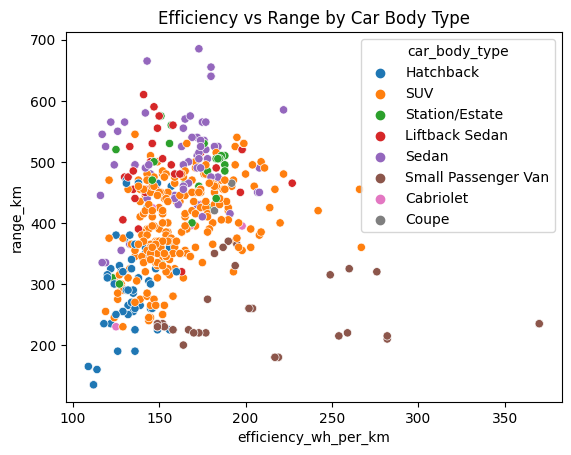

In [14]:
sns.scatterplot(data=df, x='efficiency_wh_per_km', y='range_km', hue='car_body_type')
plt.title('Efficiency vs Range by Car Body Type')
plt.show()


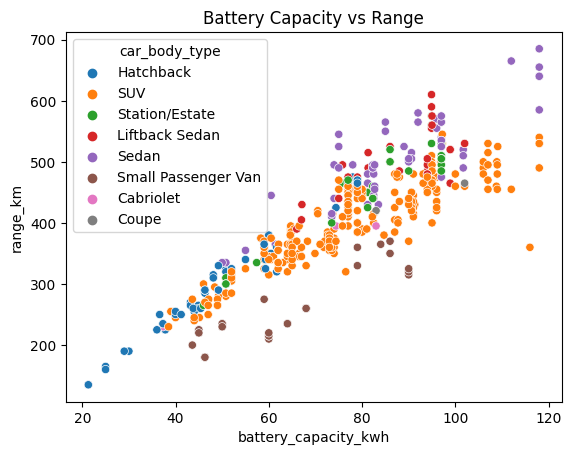

In [15]:
sns.scatterplot(data=df, x='battery_capacity_kwh', y='range_km', hue='car_body_type')
plt.title('Battery Capacity vs Range')
plt.show()


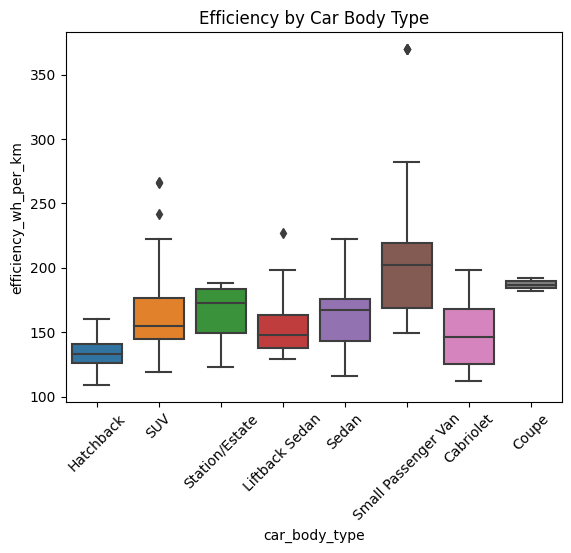

In [16]:
sns.boxplot(data=df, x='car_body_type', y='efficiency_wh_per_km')
plt.xticks(rotation=45)
plt.title('Efficiency by Car Body Type')
plt.show()


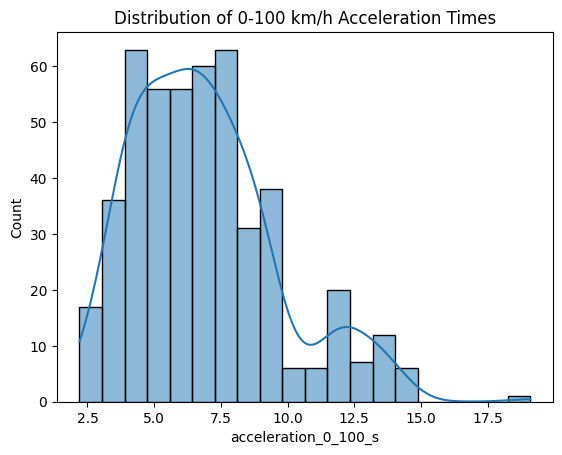

In [17]:
sns.histplot(df['acceleration_0_100_s'], bins=20, kde=True)
plt.title('Distribution of 0-100 km/h Acceleration Times')
plt.show()


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

# Επιλογή χαρακτηριστικών
features = ['battery_capacity_kwh', 'efficiency_wh_per_km', 'torque_nm',
            'acceleration_0_100_s', 'seats']
df_clean = df[features + ['range_km']].dropna()

X = df_clean[features]
y = df_clean['range_km']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
print("MAE:", mean_absolute_error(y_test, y_pred))


MAE: 18.36068421052632


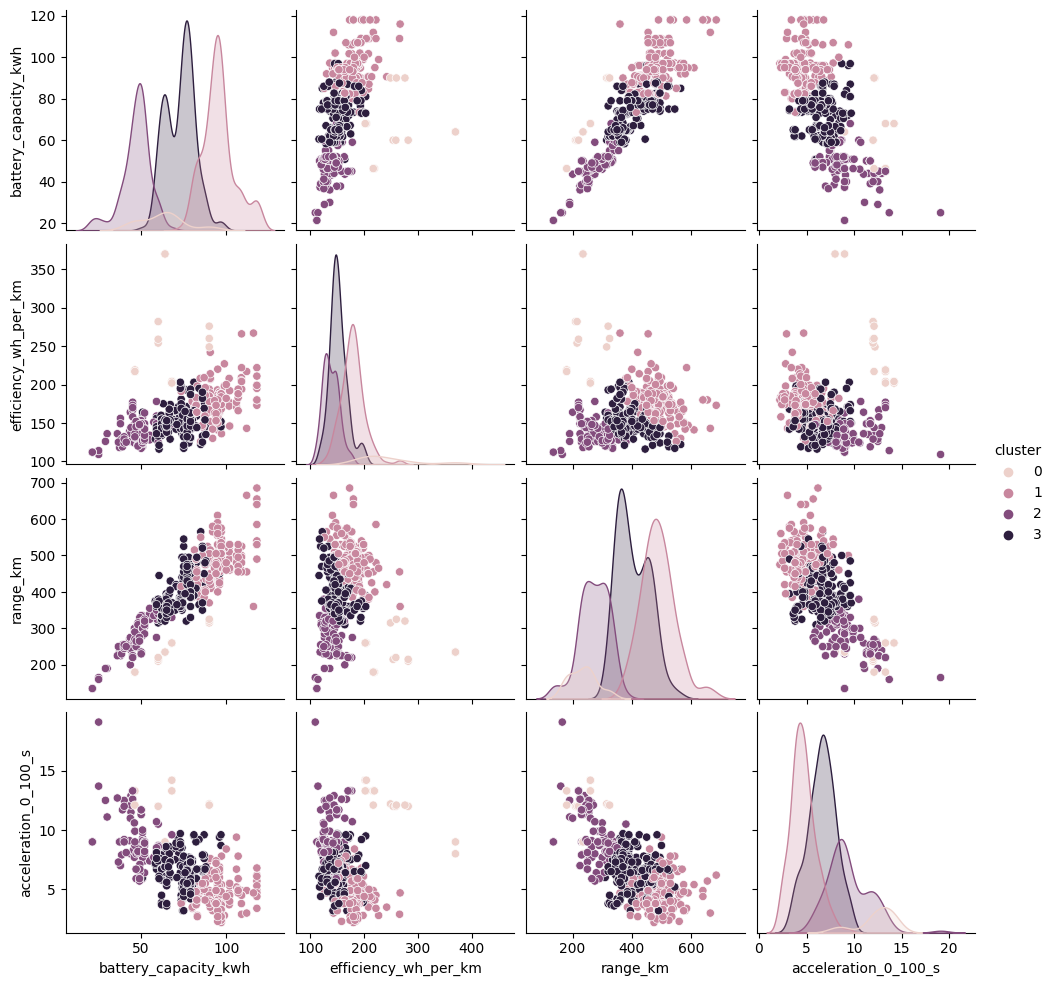

In [19]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = ['battery_capacity_kwh', 'efficiency_wh_per_km', 'range_km', 'acceleration_0_100_s']
df_cluster = df[features].dropna()

X_scaled = StandardScaler().fit_transform(df_cluster)

kmeans = KMeans(n_clusters=4, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

sns.pairplot(df, vars=features, hue='cluster')
plt.show()


In [21]:
# Προετοιμασία: μετατρέπουμε τις αριθμητικές στήλες σε float
columns_to_check = list(features_max.keys()) + list(features_min.keys())

for col in columns_to_check:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')  # μετατροπή σε αριθμούς, αγνόηση λάθους


In [22]:
print("🔝 BEST ELECTRIC VEHICLES FOR 2025 FEATURES:\n")

# Μέγιστες τιμές = καλύτερες
for col, desc in features_max.items():
    if col in df.columns:
        best = df.loc[df[col].idxmax()]
        print(f"✅ {desc}: {best['brand']} {best['model']} - {best[col]}")

# Ελάχιστες τιμές = καλύτερες
for col, desc in features_min.items():
    if col in df.columns:
        best = df.loc[df[col].idxmin()]
        print(f"⚡ {desc}: {best['brand']} {best['model']} - {best[col]}")


🔝 BEST ELECTRIC VEHICLES FOR 2025 FEATURES:

✅ Top Speed (km/h): Maserati GranTurismo Folgore - 325
✅ Battery Capacity (kWh): Mercedes-Benz EQS 450 4MATIC - 118.0
✅ Torque (Nm): Maserati GranCabrio Folgore - 1350.0
✅ Range (km): Mercedes-Benz EQS 450+ - 685
✅ Fast Charging Power (kW): Audi e-tron GT RS - 281.0
✅ Towing Capacity (kg): BMW iX M70 xDrive - 2500.0
✅ Cargo Volume (L): Mercedes-Benz EQV 250 Extra-Long - 1410.0
✅ Number of Seats: Citroen e-SpaceTourer M 50 kWh - 9
✅ Longest EV: Ford e-Tourneo Custom L2 160 kW - 5908
✅ Widest EV: Rolls-Royce Spectre - 2080
✅ Tallest EV: Mercedes-Benz G 580 - 1986
⚡ Best Efficiency (Wh/km): Dacia Spring Electric 45 - 109
⚡ Fastest Acceleration (0-100 km/h): Porsche Taycan Turbo GT Weissach - 2.2


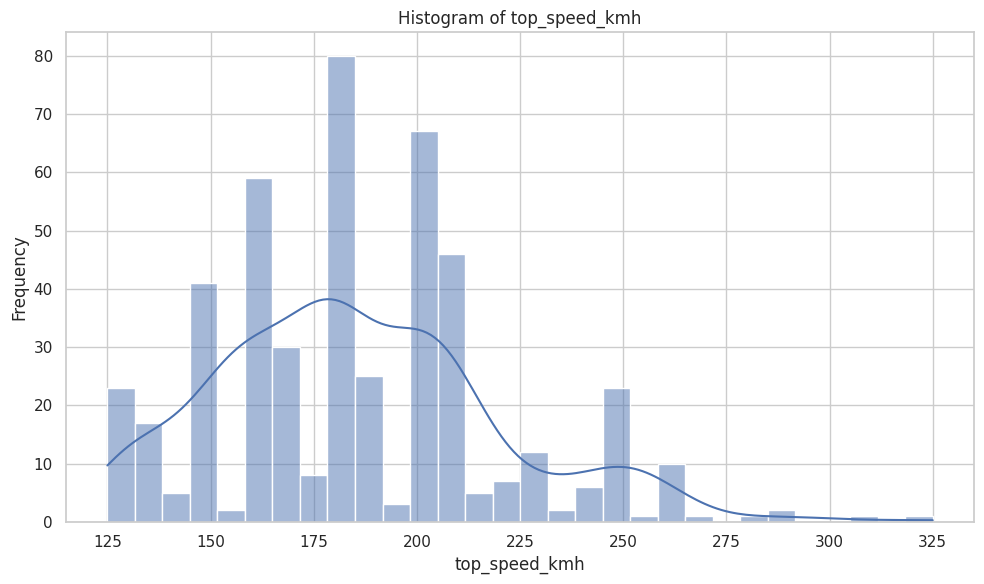

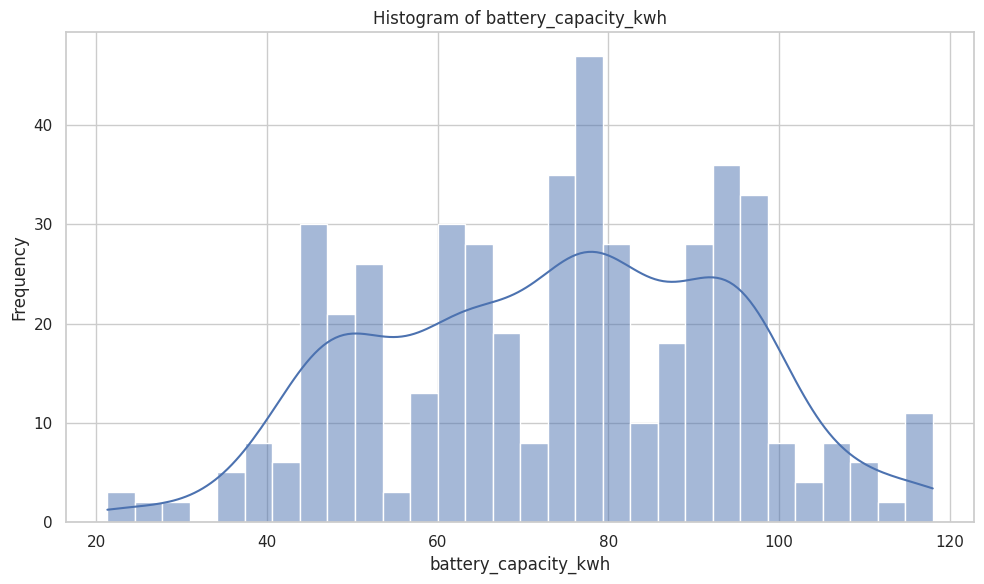

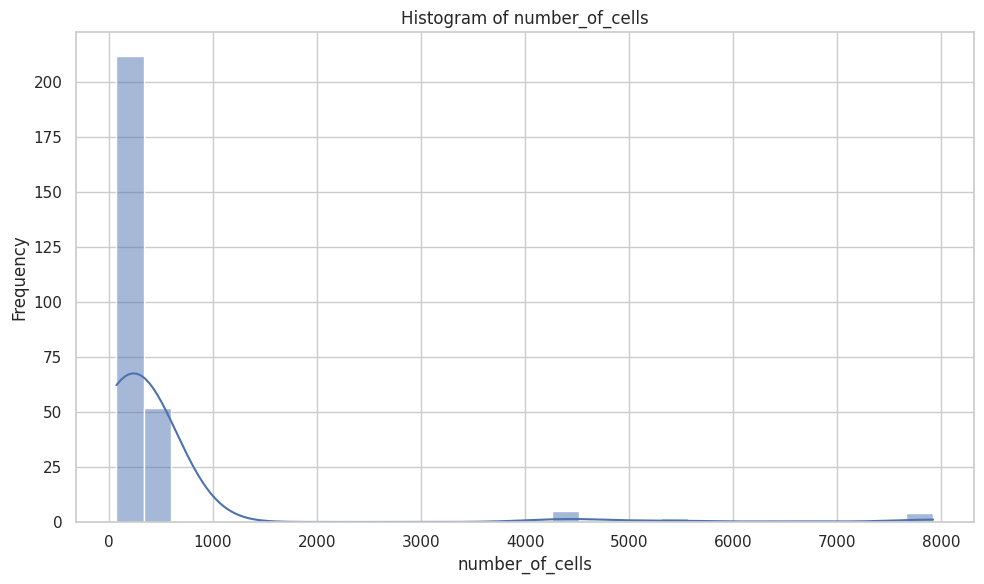

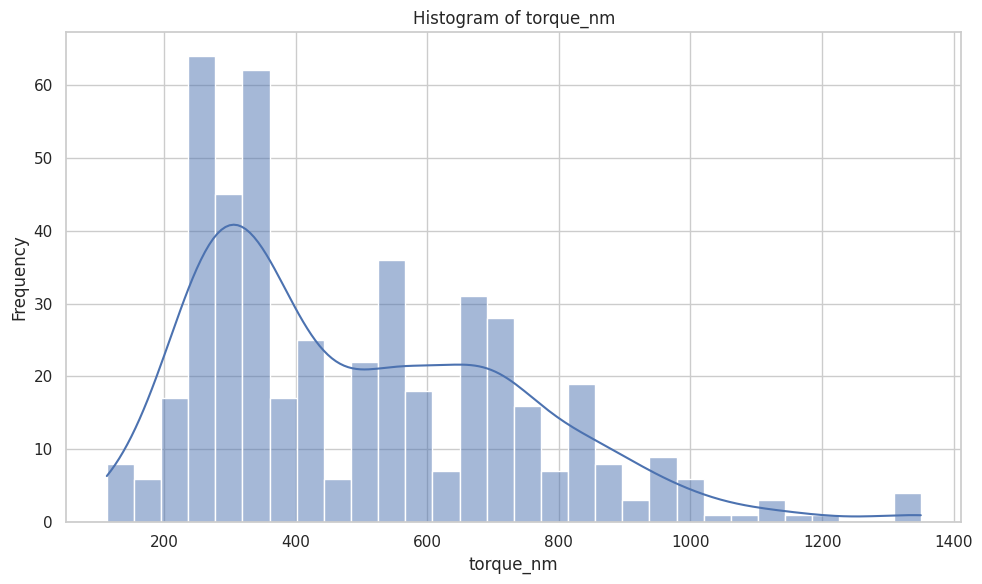

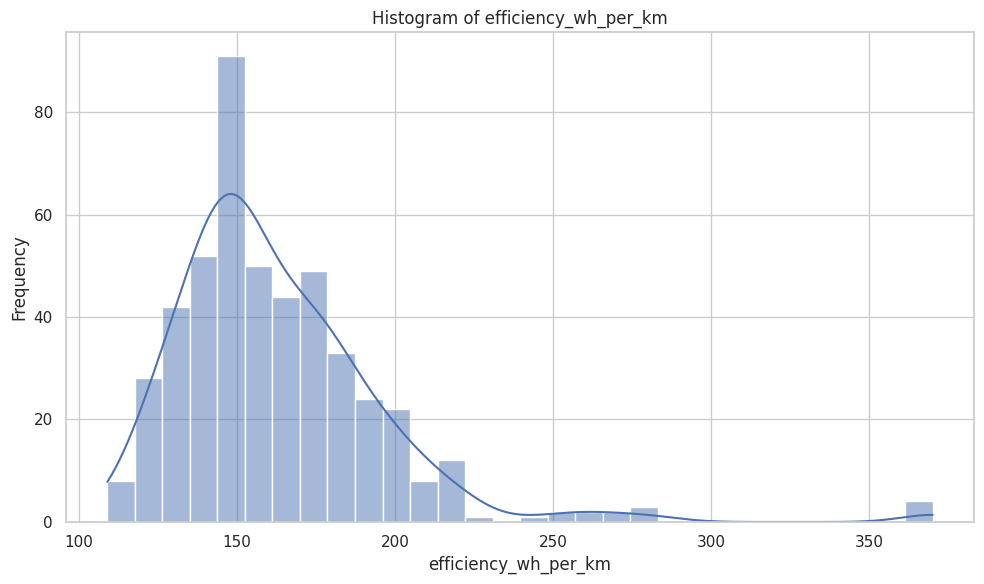

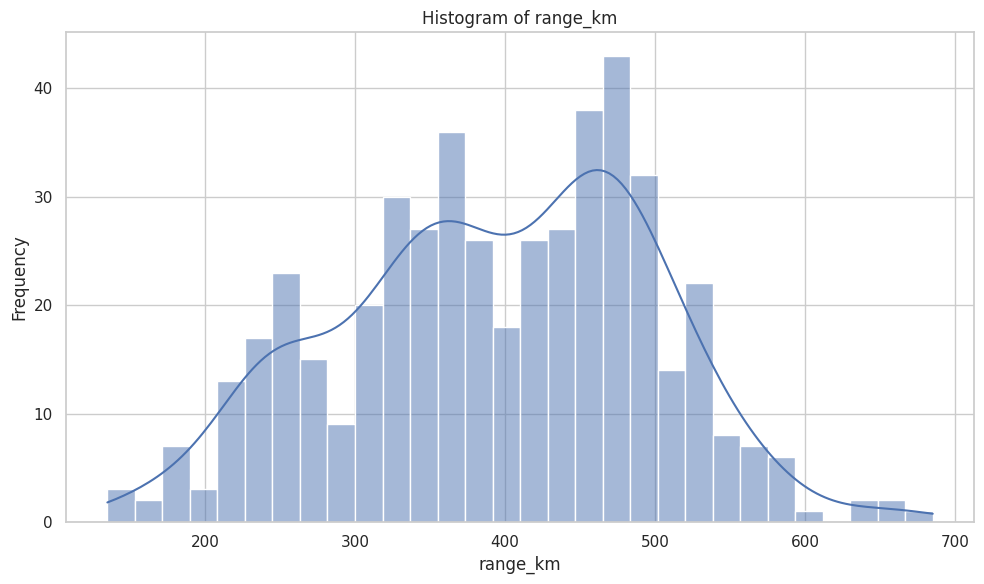

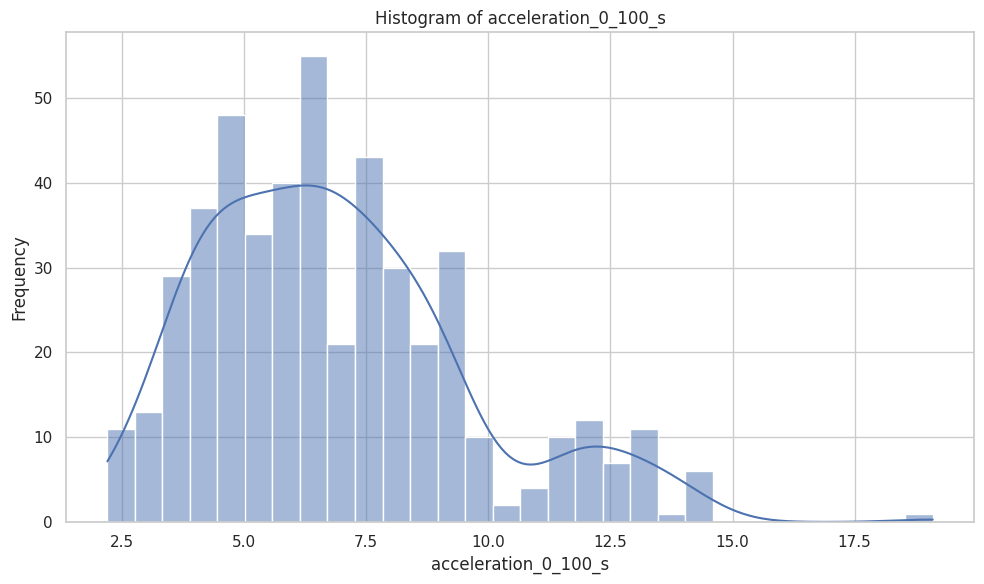

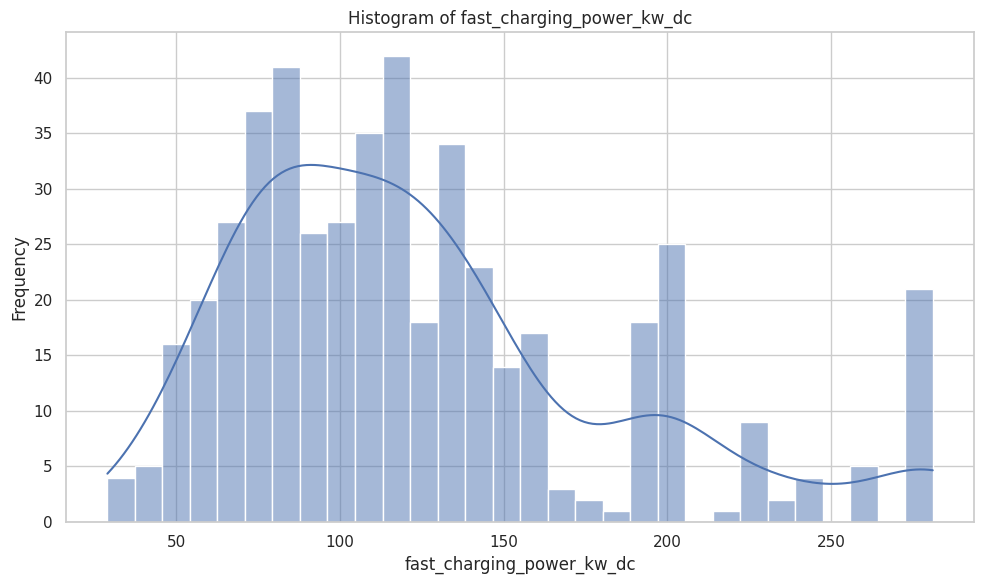

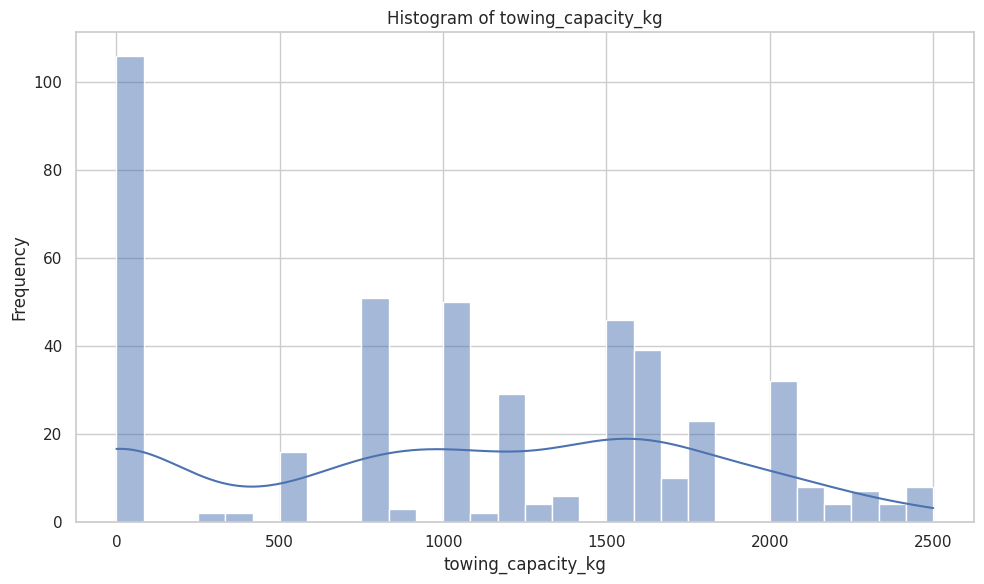

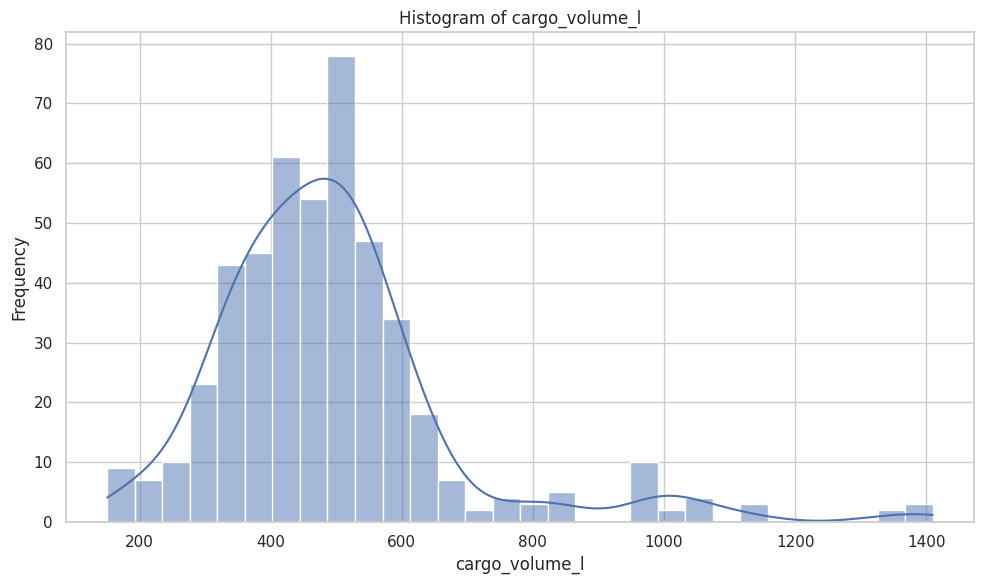

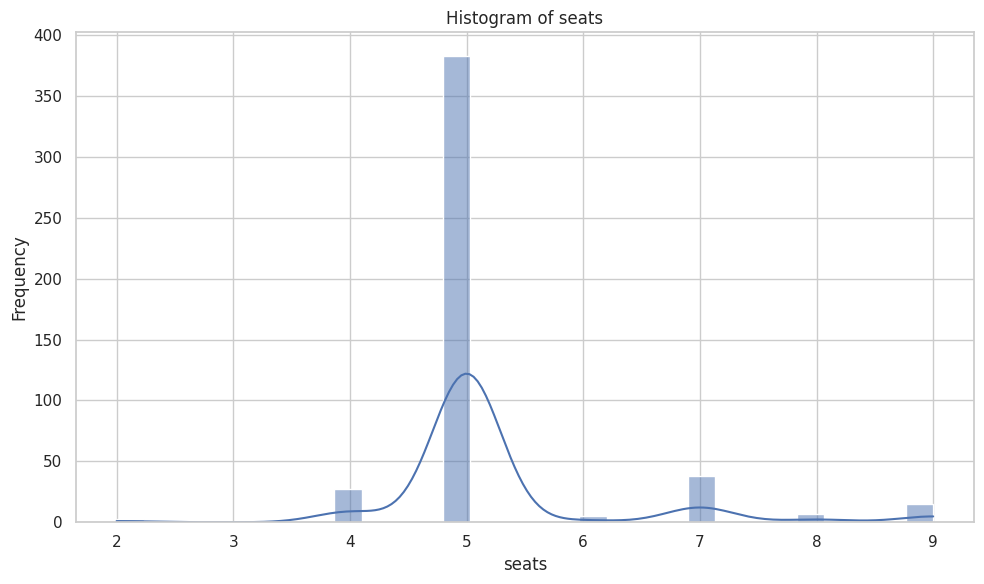

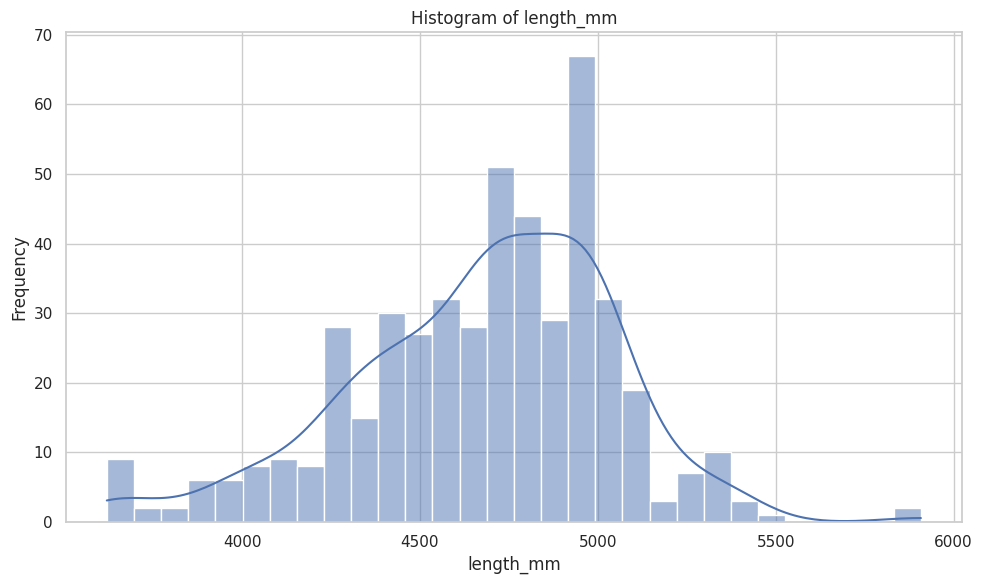

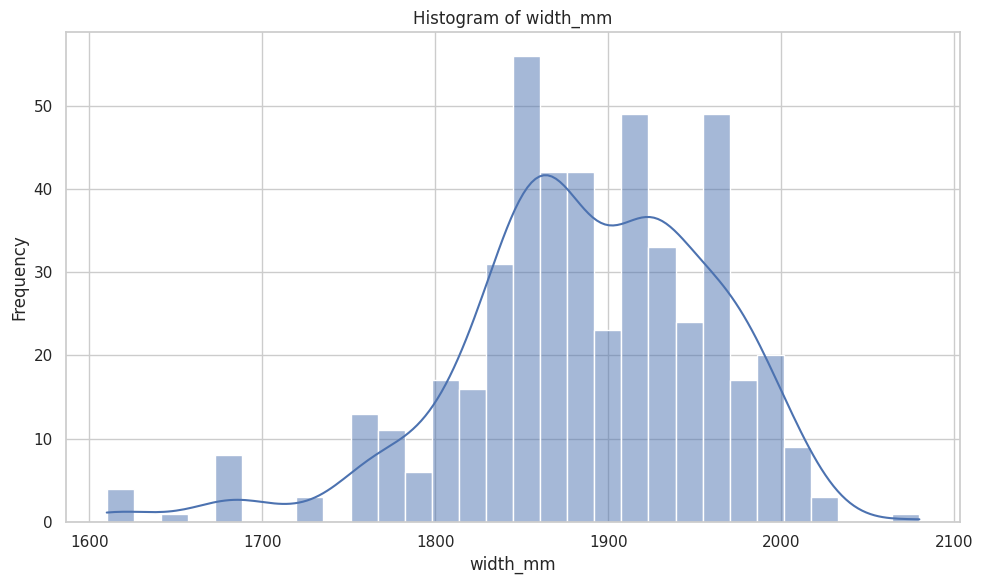

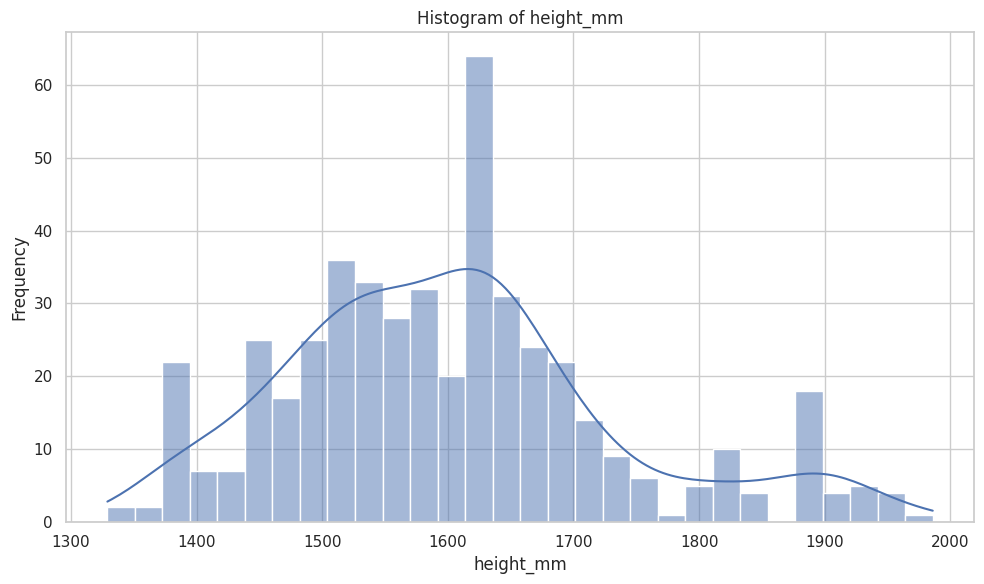

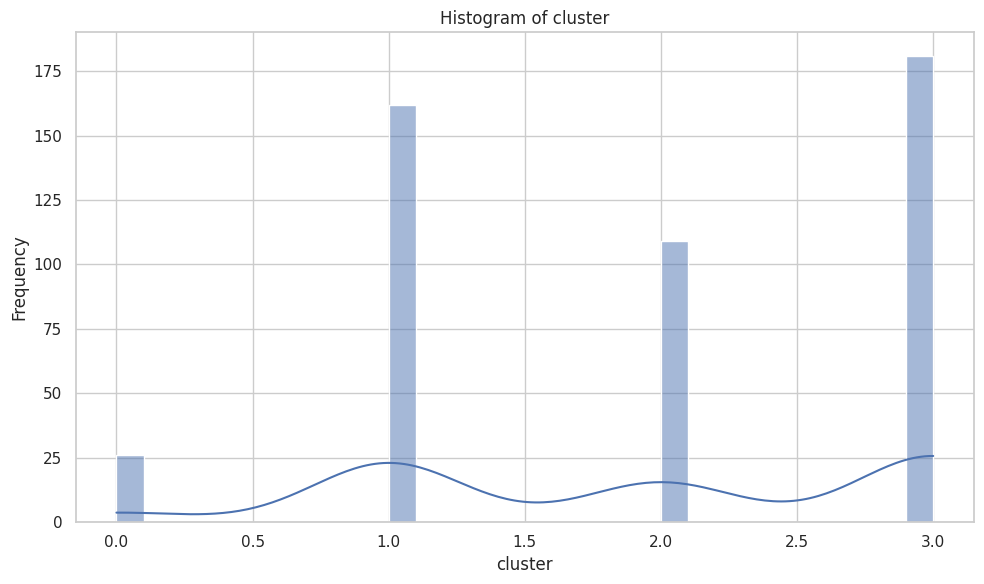

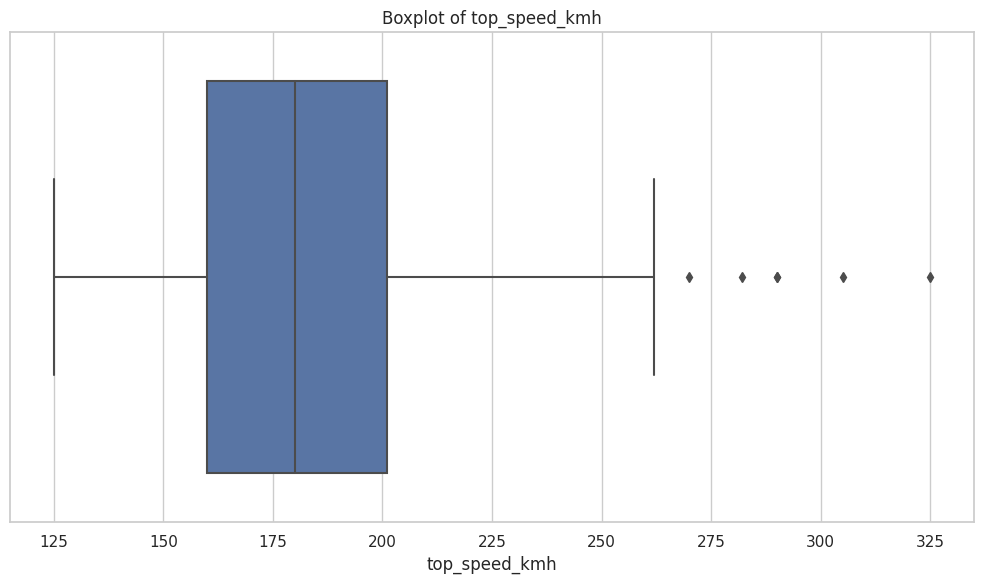

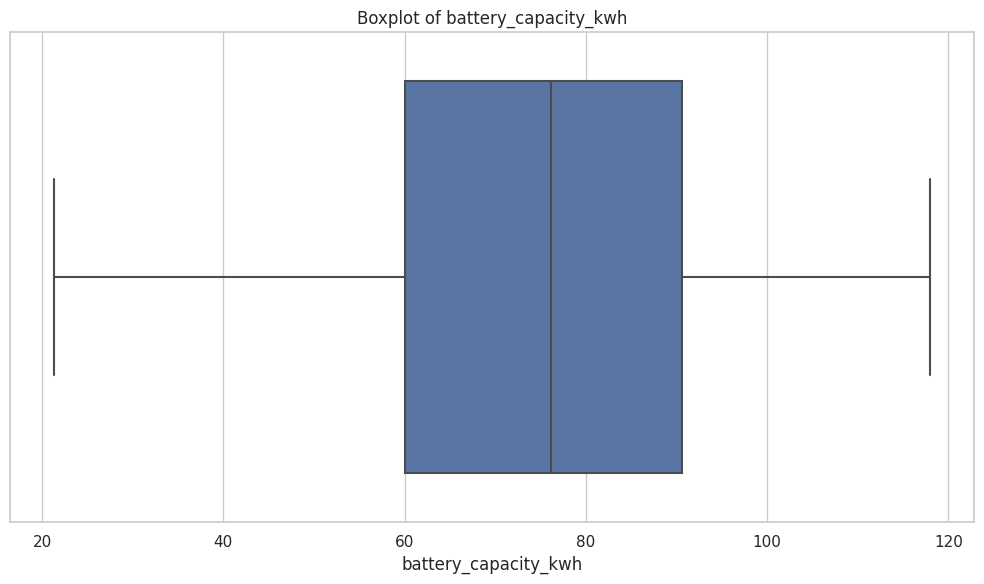

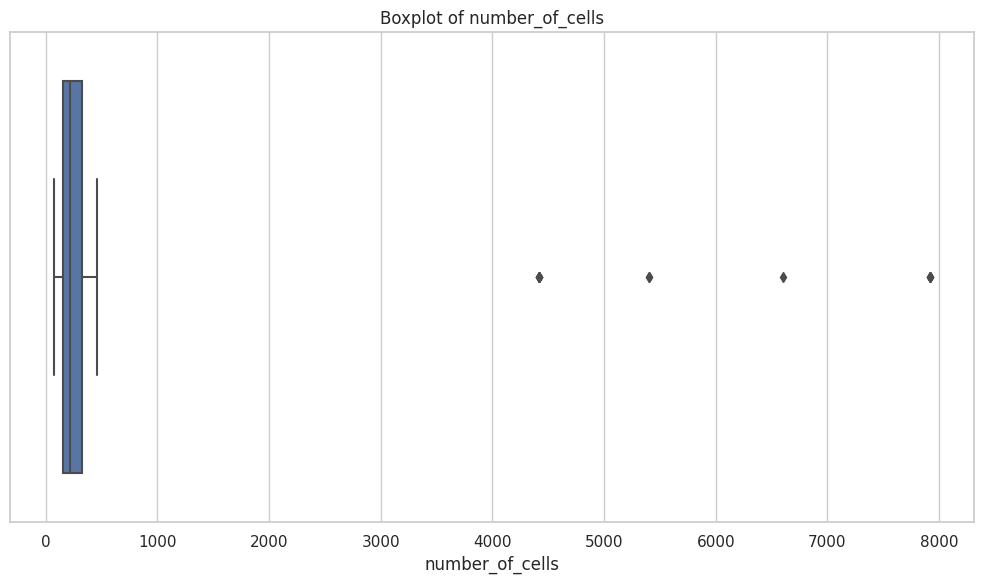

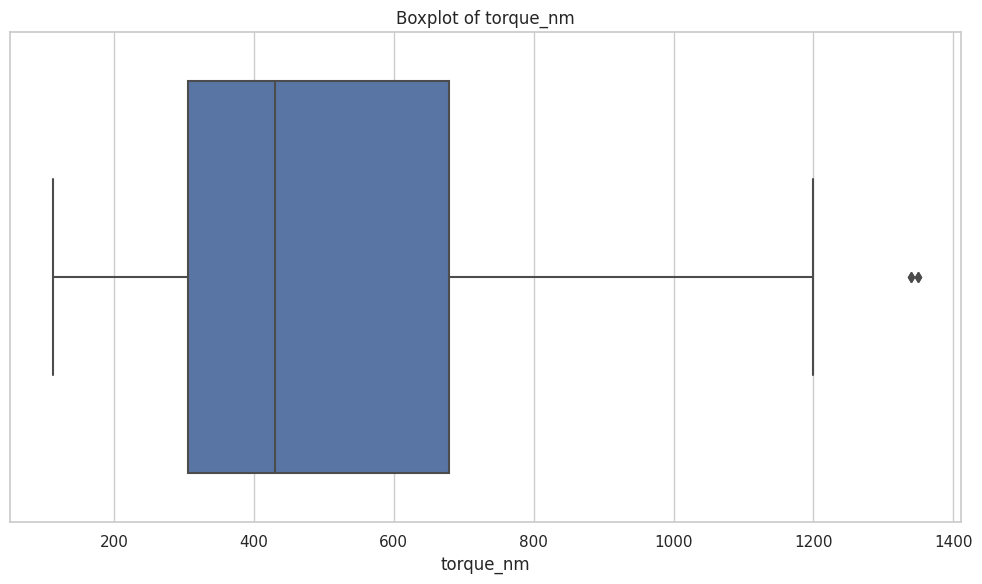

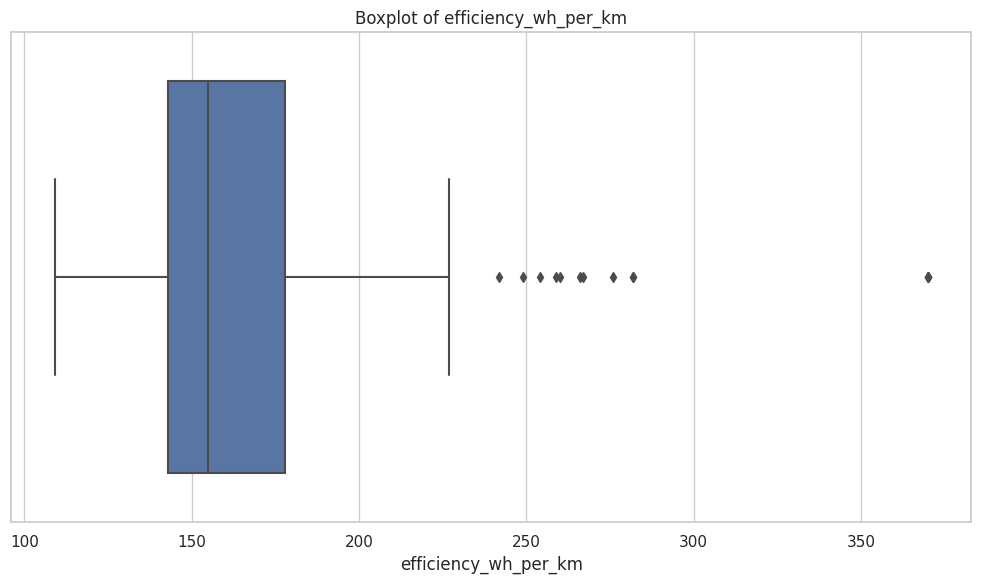

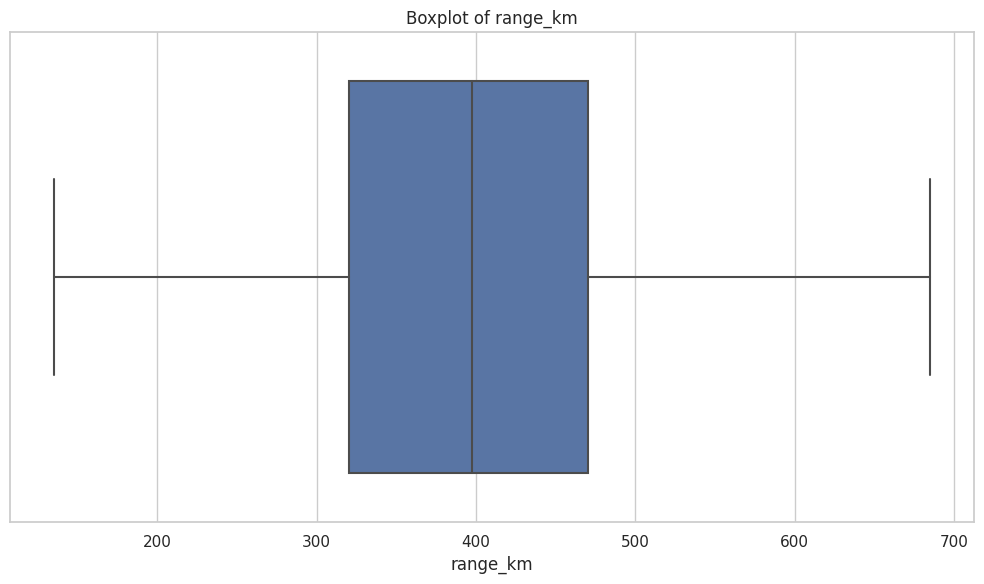

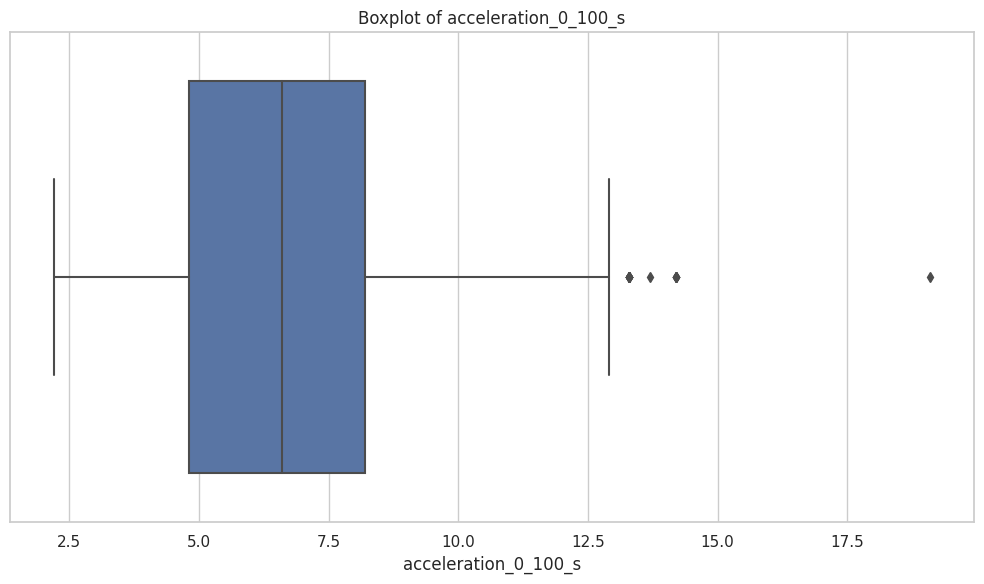

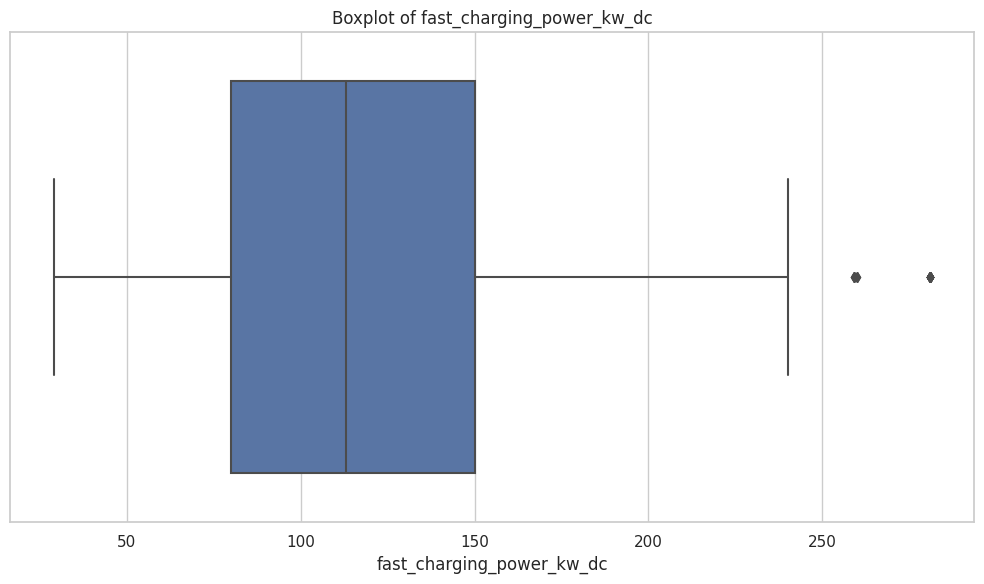

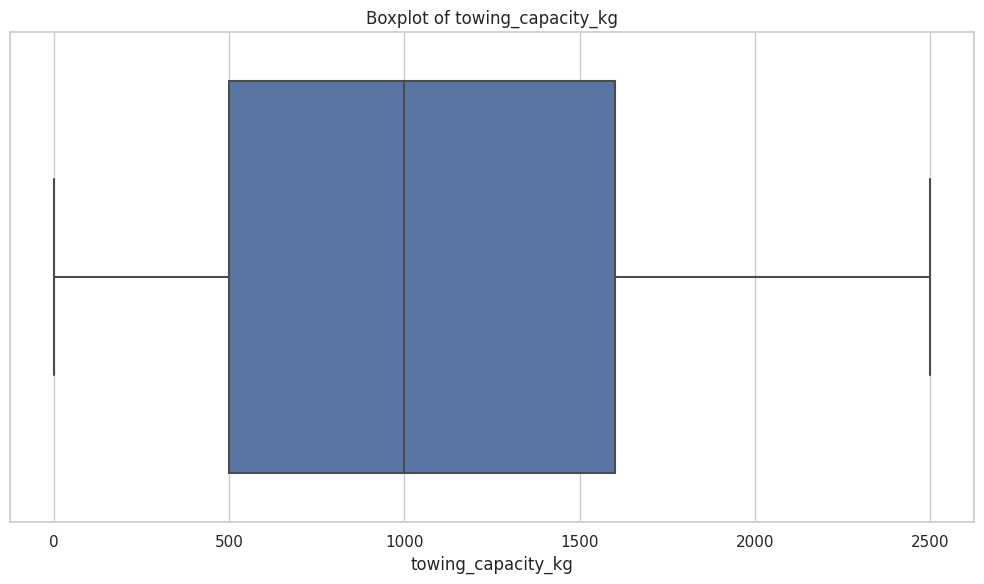

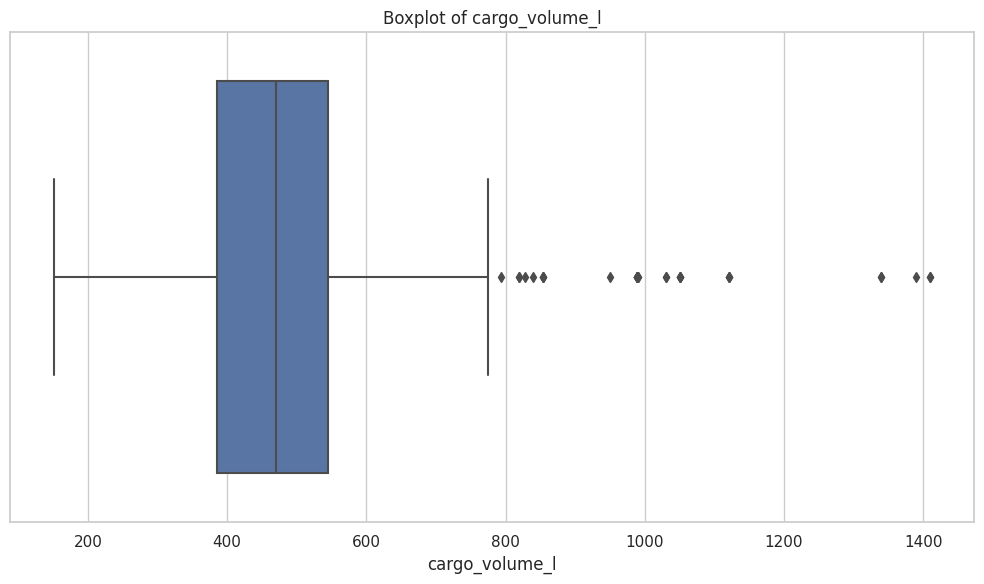

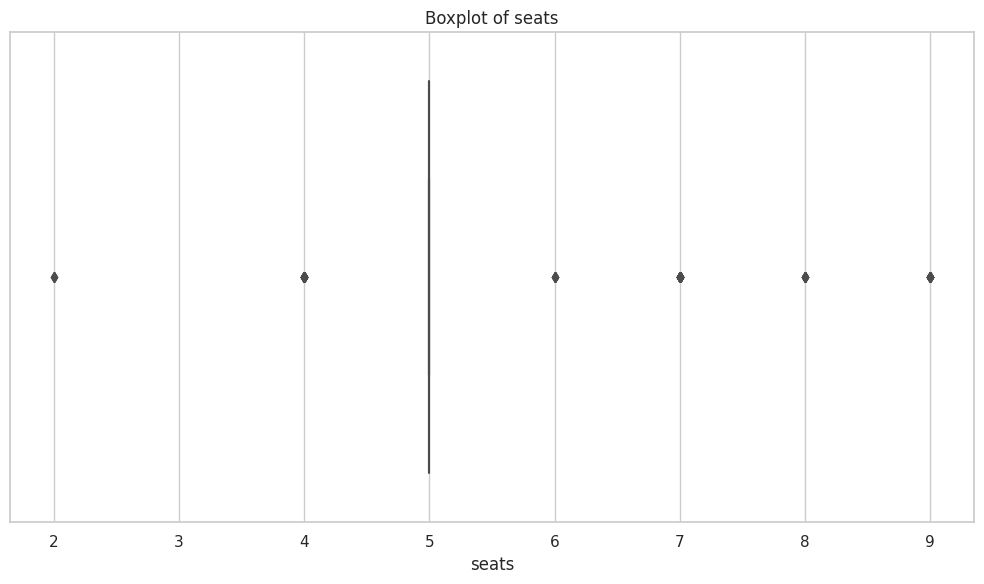

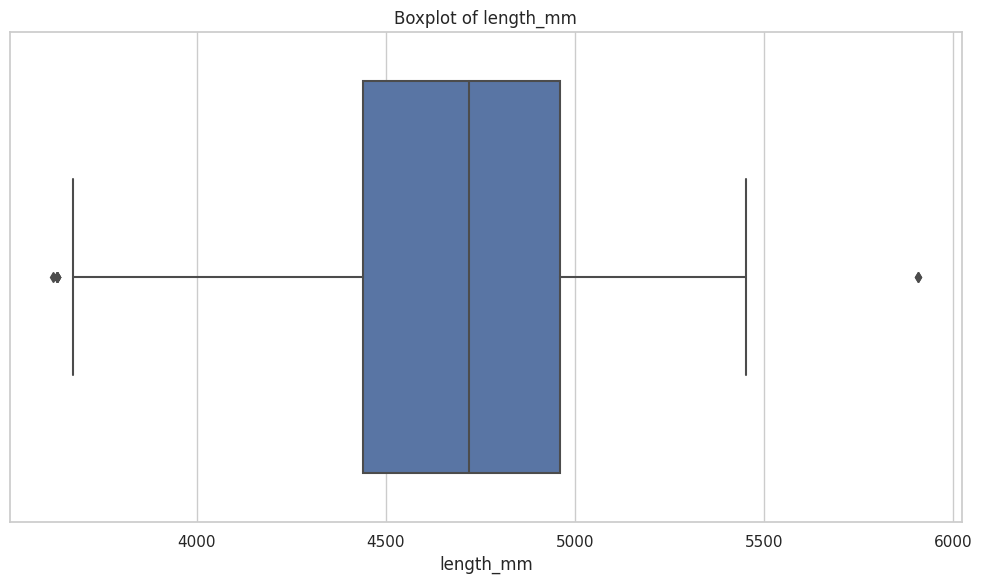

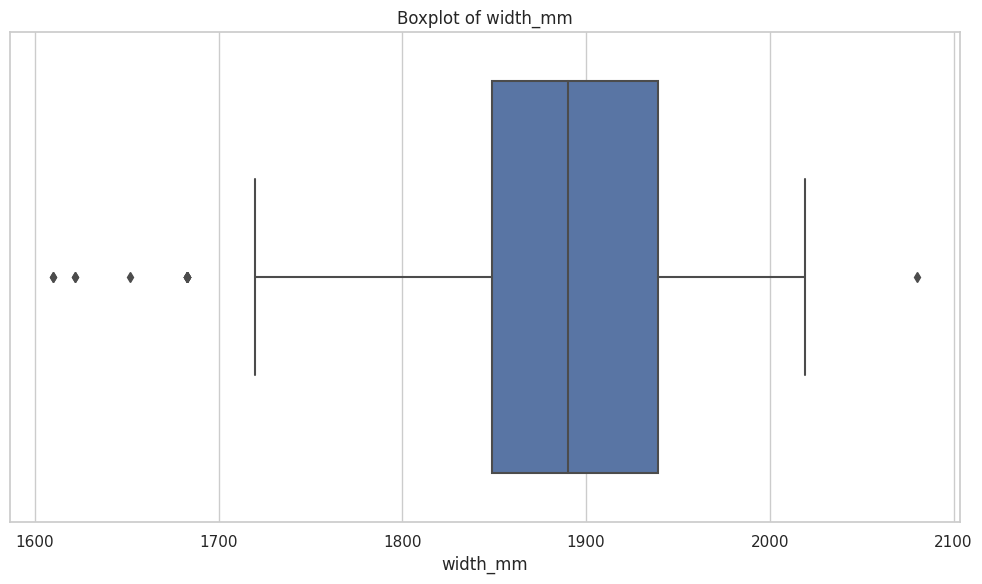

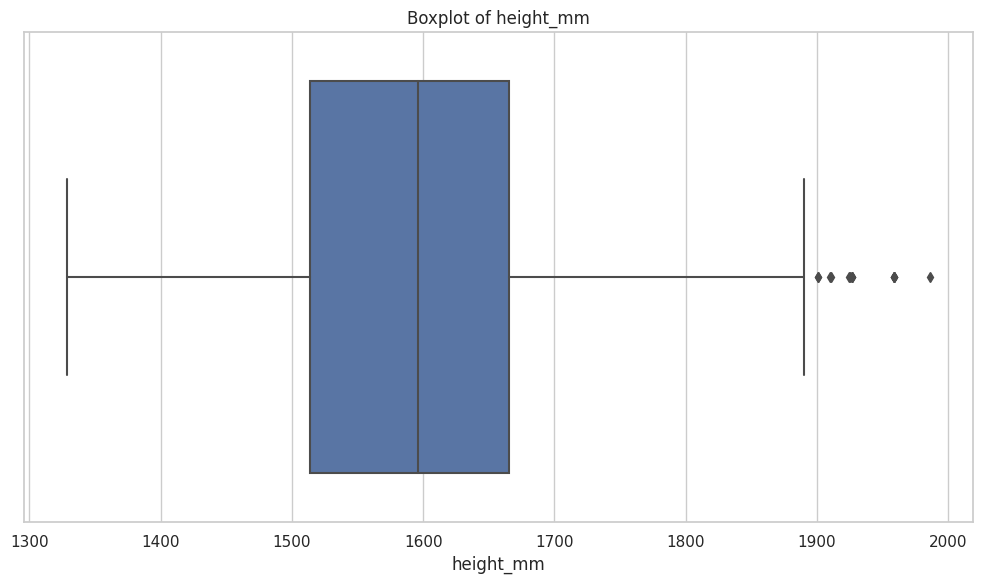

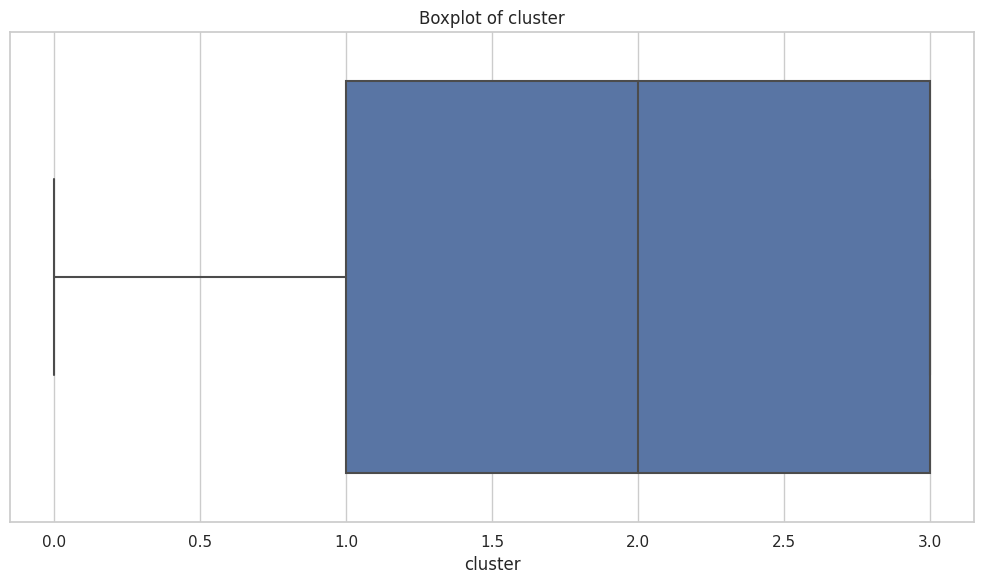

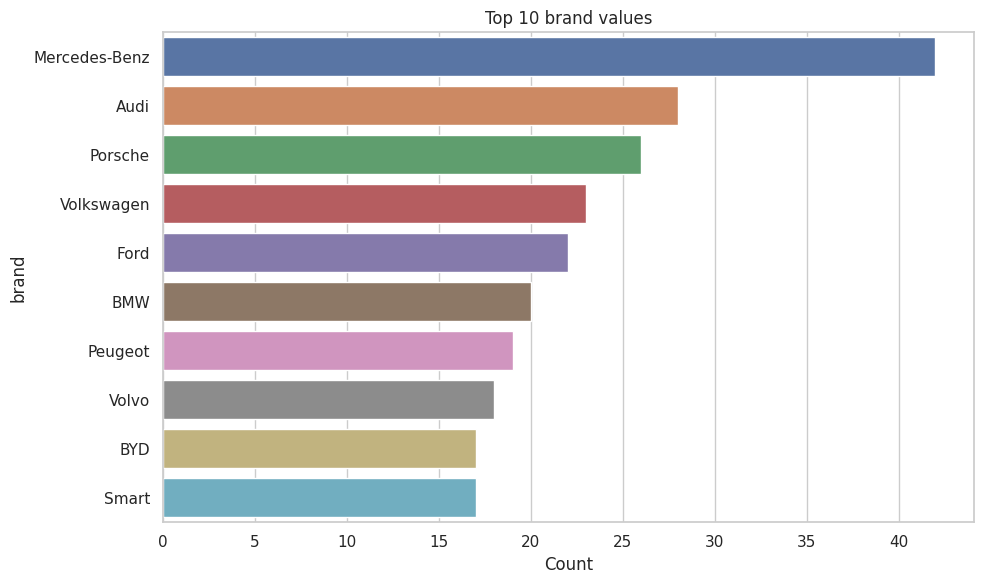

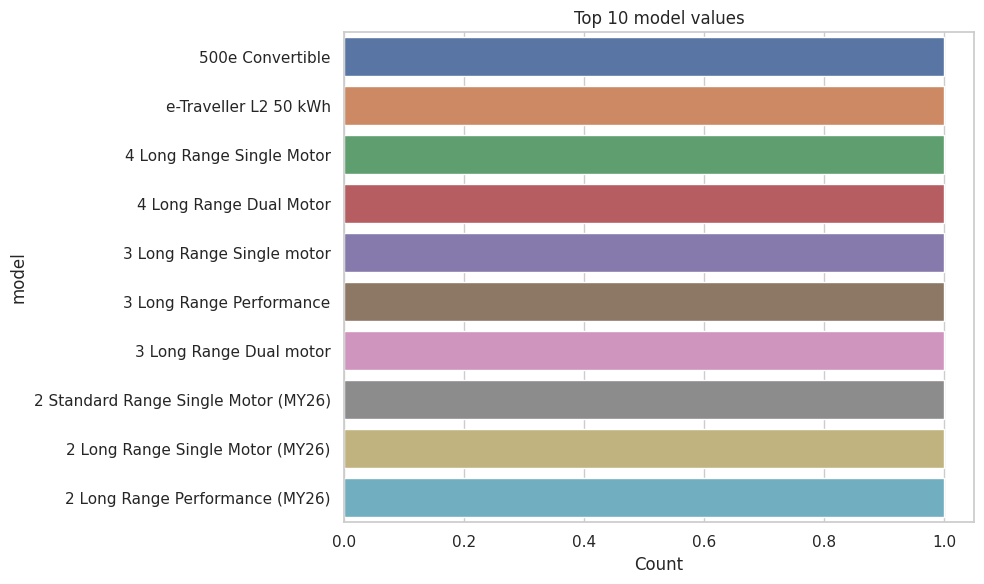

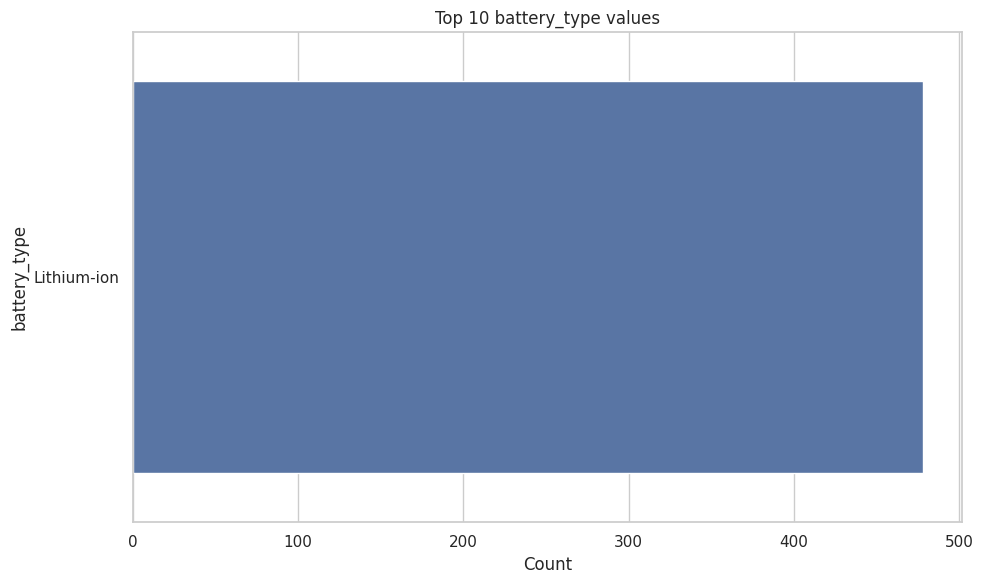

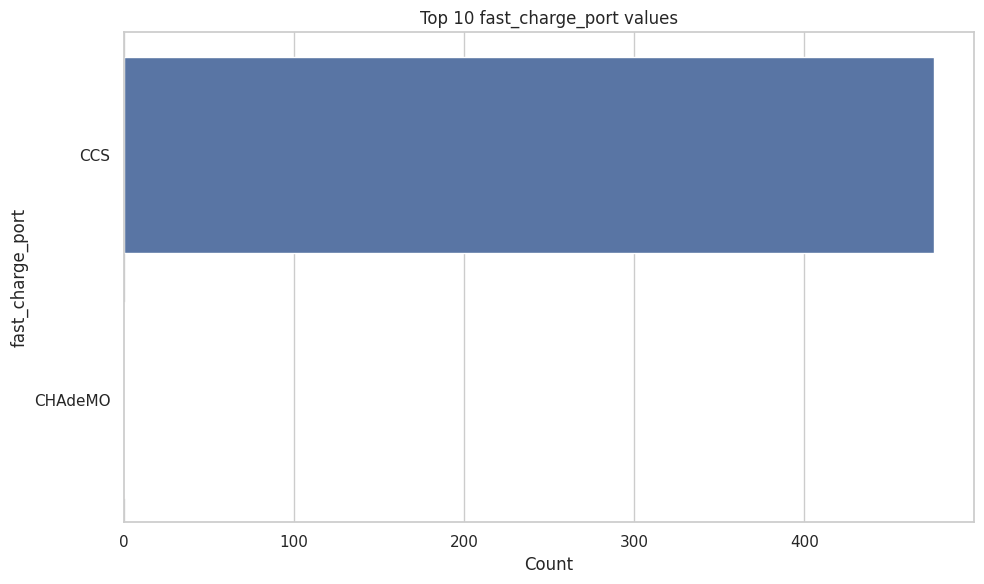

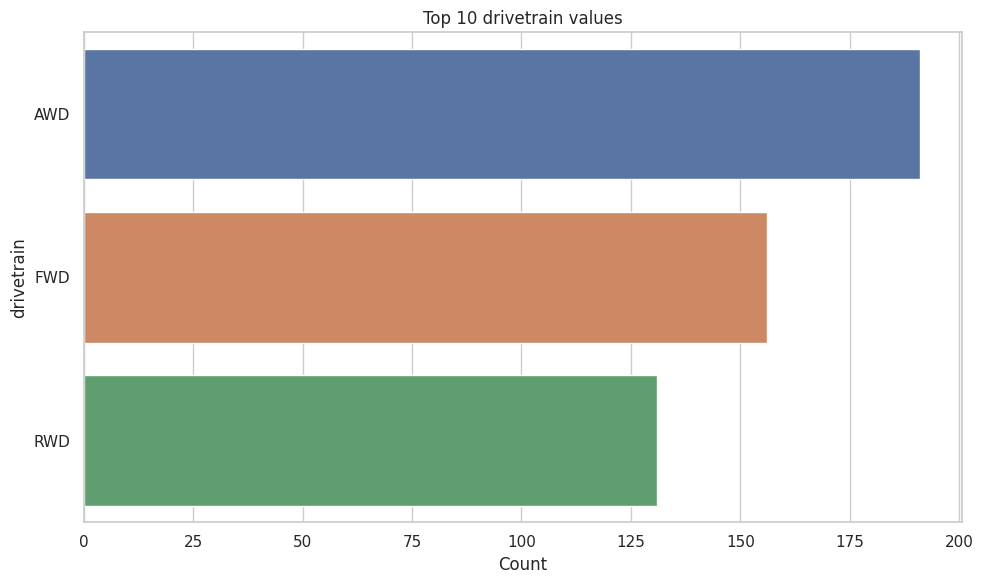

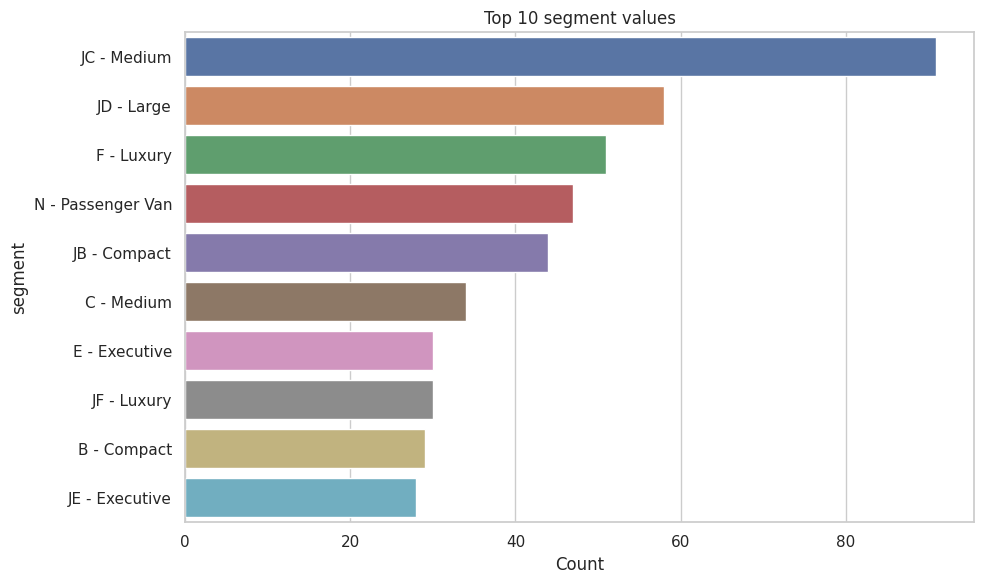

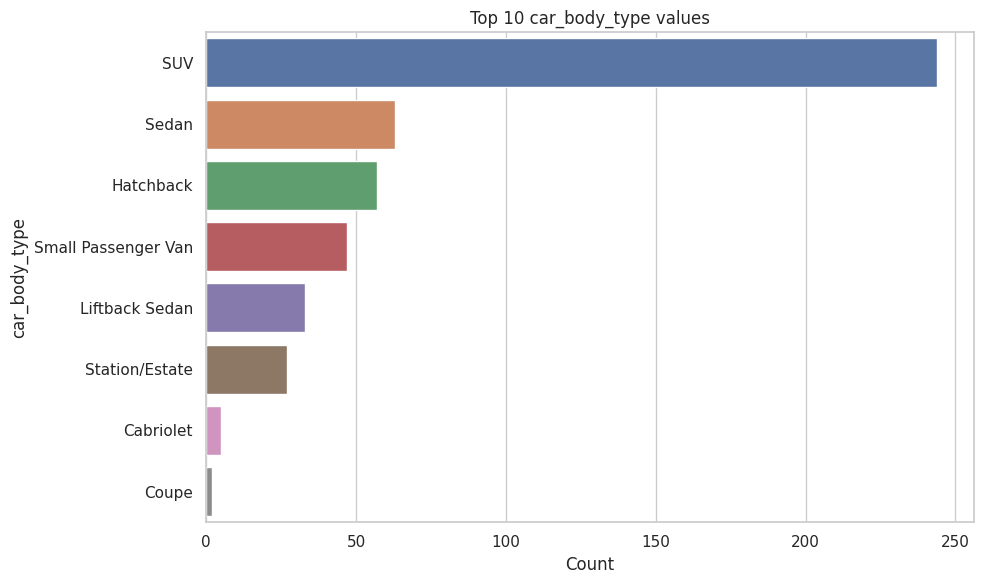

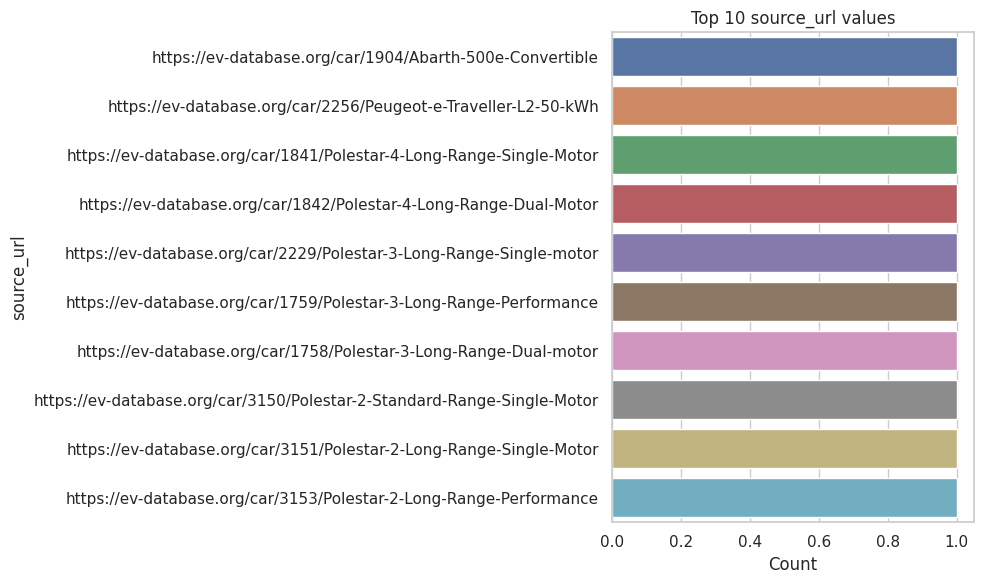

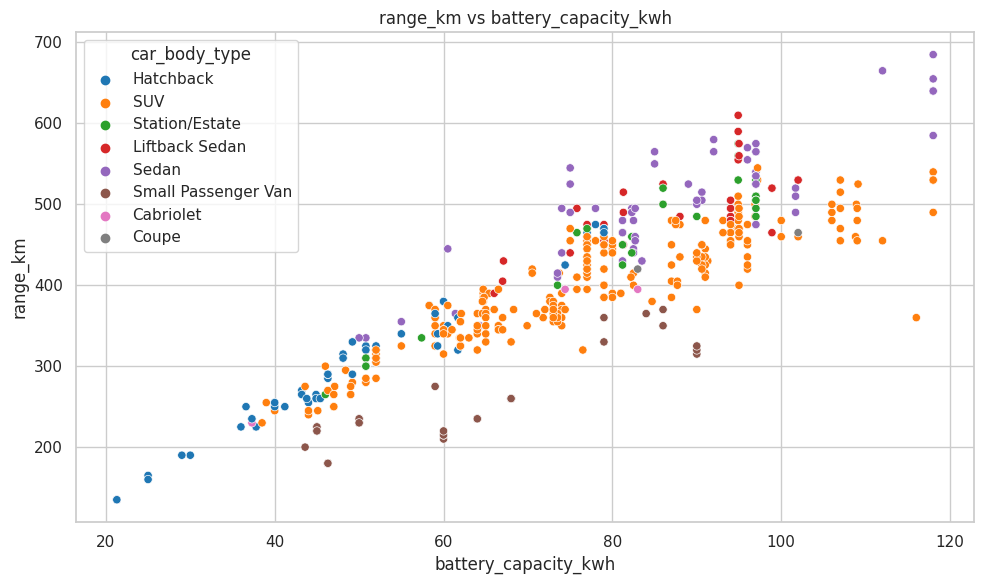

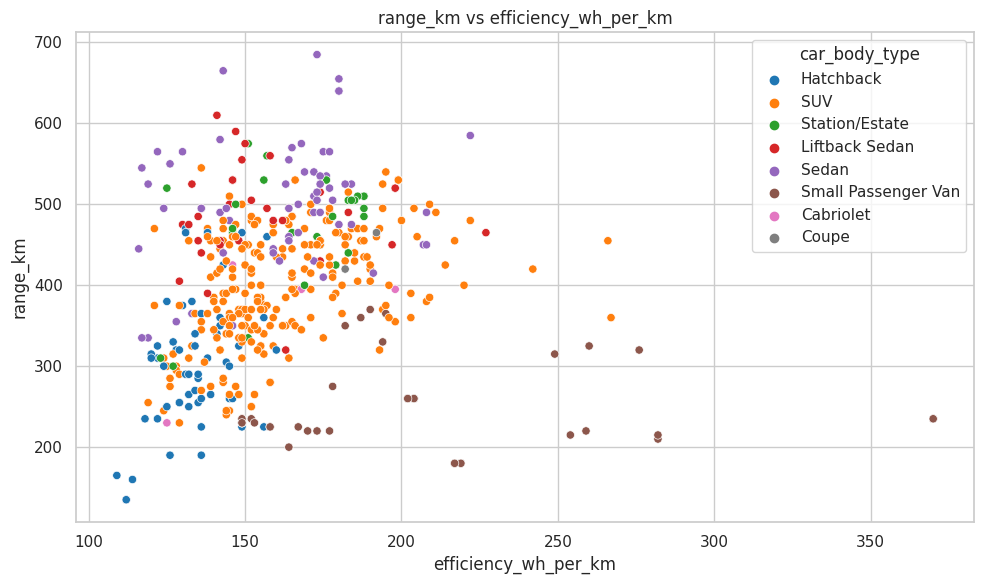

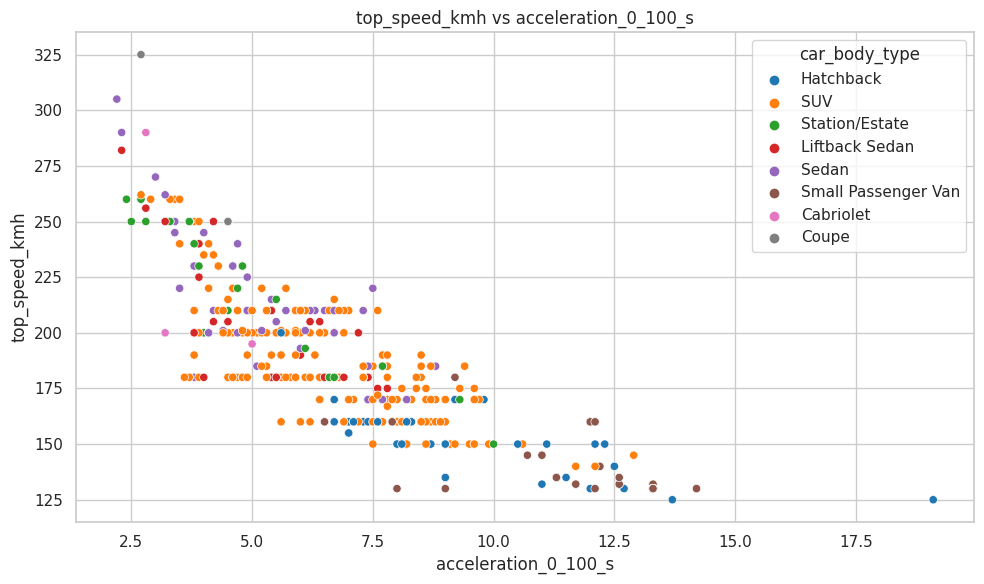

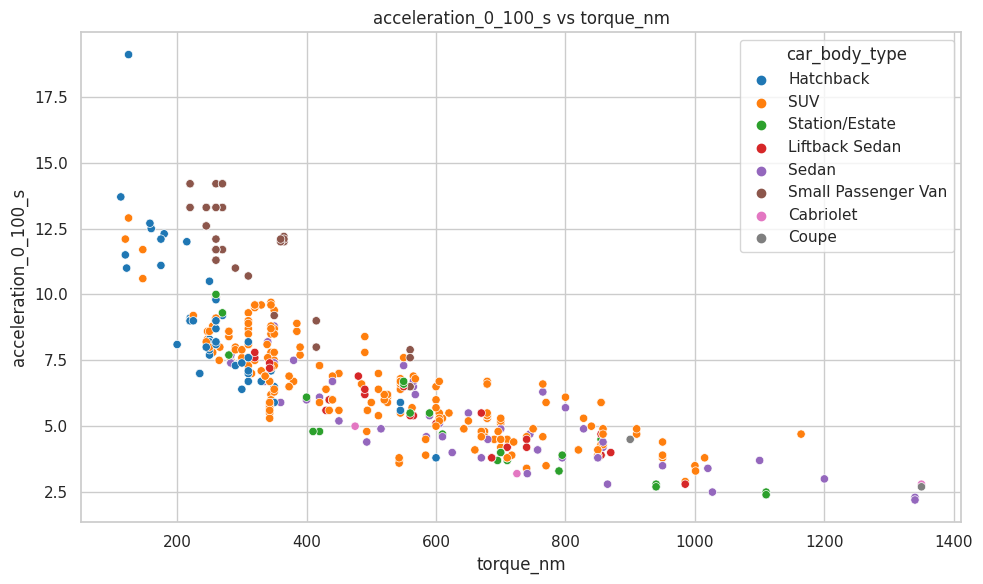

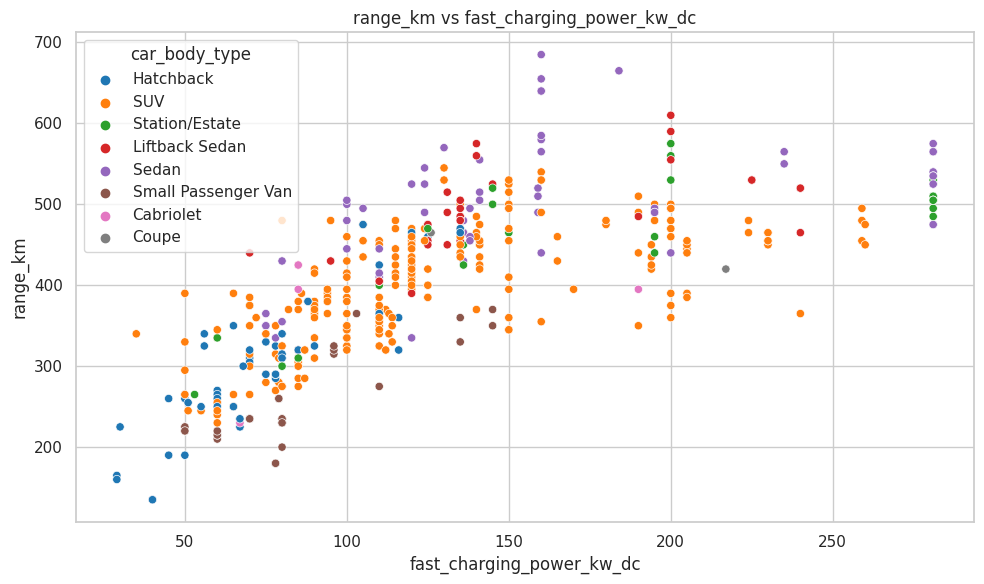

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Μετατροπή όλων των αριθμητικών πεδίων σε float
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
for col in numeric_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Κατηγορικές στήλες
categorical_columns = df.select_dtypes(include='object').columns.tolist()

# -----------------------------
# 📊 HISTOGRAM για αριθμητικά
# -----------------------------
for col in numeric_columns:
    plt.figure()
    sns.histplot(df[col], bins=30, kde=True)
    plt.title(f"Histogram of {col}")
    plt.xlabel(col)
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 📉 BOXPLOT για αριθμητικά
# -----------------------------
for col in numeric_columns:
    plt.figure()
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")
    plt.tight_layout()
    plt.show()

# -----------------------------
# 📈 BARPLOTS για κατηγορικές
# -----------------------------
for col in categorical_columns:
    plt.figure()
    top_vals = df[col].value_counts().head(10)
    sns.barplot(x=top_vals.values, y=top_vals.index)
    plt.title(f"Top 10 {col} values")
    plt.xlabel("Count")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

# -----------------------------
# 🔍 SCATTER PLOTS μεταξύ βασικών μεγεθών
# -----------------------------
scatter_pairs = [
    ("battery_capacity_kwh", "range_km"),
    ("efficiency_wh_per_km", "range_km"),
    ("acceleration_0_100_s", "top_speed_kmh"),
    ("torque_nm", "acceleration_0_100_s"),
    ("fast_charging_power_kw_dc", "range_km"),
]

for x, y in scatter_pairs:
    if x in df.columns and y in df.columns:
        plt.figure()
        sns.scatterplot(data=df, x=x, y=y, hue="car_body_type", palette="tab10")
        plt.title(f"{y} vs {x}")
        plt.tight_layout()
        plt.show()


EV Recommendation System 

In [24]:
import pandas as pd

# Υποθετική τιμή ανά kWh
kwh_price_eur = 0.25

# Ας καθαρίσουμε τα δεδομένα
df['range_km'] = pd.to_numeric(df['range_km'], errors='coerce')
df['cargo_volume_l'] = pd.to_numeric(df['cargo_volume_l'], errors='coerce')
df['efficiency_wh_per_km'] = pd.to_numeric(df['efficiency_wh_per_km'], errors='coerce')

# Αν έχεις στήλη 'price_eur' βάλε φίλτρο. Αλλιώς αφαίρεσέ το.
has_price = 'price_eur' in df.columns
if has_price:
    df['price_eur'] = pd.to_numeric(df['price_eur'], errors='coerce')

# Κριτήρια επιλογής
filtered = df[
    (df['range_km'] >= 400) &
    (df['cargo_volume_l'] >= 500)
]

if has_price:
    max_price = 60000  # βάλε όριο τιμής
    filtered = filtered[filtered['price_eur'] <= max_price]

# Υπολογισμός κόστους ανά 100km
filtered['cost_per_100km_eur'] = (filtered['efficiency_wh_per_km'] / 1000) * kwh_price_eur * 100

# Επιλογή βασικών πεδίων για προβολή
result = filtered[[
    'brand', 'model', 'range_km', 'cargo_volume_l', 'efficiency_wh_per_km',
    'fast_charging_power_kw_dc', 'drivetrain', 'seats'
]]

if has_price:
    result['price_eur'] = filtered['price_eur']

result['cost_per_100km_eur'] = filtered['cost_per_100km_eur'].round(2)

# Ταξινόμηση κατά αυτονομία ή κόστος
result = result.sort_values(by='range_km', ascending=False)

# Εμφάνιση top 10 EVs που ταιριάζουν
result.head(10)


brand                            model  range_km  cargo_volume_l  \
239  Mercedes-Benz                         EQS 450+       685           620.0   
238  Mercedes-Benz                   EQS 450 4MATIC       655           620.0   
240  Mercedes-Benz                   EQS 500 4MATIC       640           620.0   
241  Mercedes-Benz                   EQS 580 4MATIC       640           620.0   
14            Audi  A6 Sportback e-tron performance       610           502.0   
15            Audi      A6 Sportback e-tron quattro       590           502.0   
242  Mercedes-Benz               EQS AMG 53 4MATIC+       585           620.0   
401          Tesla               Model S Dual Motor       575           709.0   
11            Audi      A6 Avant e-tron performance       575           502.0   
237  Mercedes-Benz                          EQS 350       570           620.0   

     efficiency_wh_per_km  fast_charging_power_kw_dc drivetrain  seats  \
239                   173                      160.0        RWD      5   
238                   180                      160.0        AWD      5   
240                   180                      160.0        AWD      5   
241                   180                      160.0        AWD      5   
14                    141                      200.0        RWD      5   
15                    147                      200.0        AWD      5   
242                   222                      160.0        AWD      5   
401                   150                      140.0        AWD      5   
11                    151                      200.0        RWD      5   
237                   165                      130.0        RWD      5   

     cost_per_100km_eur  
239                4.32  
238                4.50  
240                4.50  
241                4.50  
14                 3.52  
15                 3.68  
242                5.55  
401                3.75  
11                 3.78  
237                4.12

In [28]:
print(df.columns)


Index(['brand', 'model', 'top_speed_kmh', 'battery_capacity_kWh',
       'battery_type', 'number_of_cells', 'torque_nm', 'efficiency_wh_per_km',
       'range_km', 'acceleration_0_100_s', 'fast_charging_power_kw_dc',
       'fast_charge_port', 'towing_capacity_kg', 'cargo_volume_l', 'seats',
       'drivetrain', 'segment', 'length_mm', 'width_mm', 'height_mm',
       'car_body_type', 'source_url'],
      dtype='object')


Mean Squared Error: 520.0928441154971
R^2 Score: 0.9428524025508827


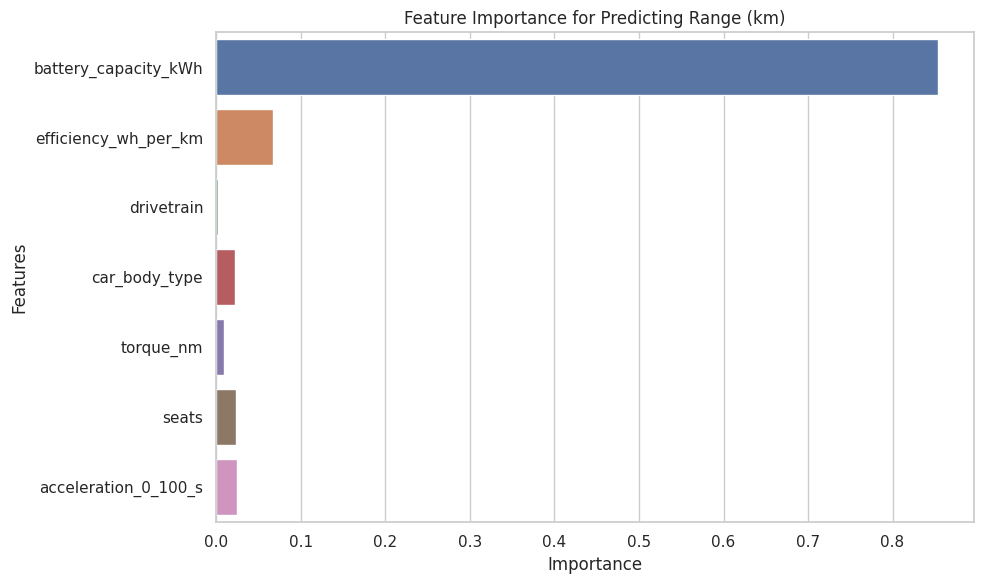

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Υποθετικός δρόμος για το dataset (αλλάξτε το με το σωστό path)
file_path = "/kaggle/input/electric-vehicle-specifications-dataset-2025/electric_vehicles_spec_2025.csv.csv"
df = pd.read_csv(file_path)

# Καθαρισμός δεδομένων
df['battery_capacity_kWh'] = pd.to_numeric(df['battery_capacity_kWh'], errors='coerce')
df['efficiency_wh_per_km'] = pd.to_numeric(df['efficiency_wh_per_km'], errors='coerce')
df['torque_nm'] = pd.to_numeric(df['torque_nm'], errors='coerce')
df['seats'] = pd.to_numeric(df['seats'], errors='coerce')
df['acceleration_0_100_s'] = pd.to_numeric(df['acceleration_0_100_s'], errors='coerce')

# Κατηγορηματικές στήλες
categorical_cols = ['drivetrain', 'car_body_type']

# Εφαρμογή LabelEncoder για κατηγορηματικές στήλες
encoder = LabelEncoder()
for col in categorical_cols:
    df[col] = encoder.fit_transform(df[col].astype(str))

# Αφαίρεση NaN τιμών
df = df.dropna(subset=['range_km', 'battery_capacity_kWh', 'efficiency_wh_per_km', 'torque_nm', 'seats', 'acceleration_0_100_s'])

# Χαρακτηριστικά (features) και στόχος (target)
X = df[['battery_capacity_kWh', 'efficiency_wh_per_km', 'drivetrain', 'car_body_type', 'torque_nm', 'seats', 'acceleration_0_100_s']]
y = df['range_km']

# Διάσπαση σε σύνολο εκπαίδευσης και δοκιμής
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Δημιουργία και εκπαίδευση του μοντέλου
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Πρόβλεψη και αξιολόγηση του μοντέλου
y_pred = model.predict(X_test)

# Υπολογισμός μετρικών
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R^2 Score: {r2}')

# Διαγράμματα Feature Importance
feature_importance = model.feature_importances_
feature_names = X.columns

# Δημιουργία του γραφήματος
plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=feature_names)
plt.title("Feature Importance for Predicting Range (km)")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()


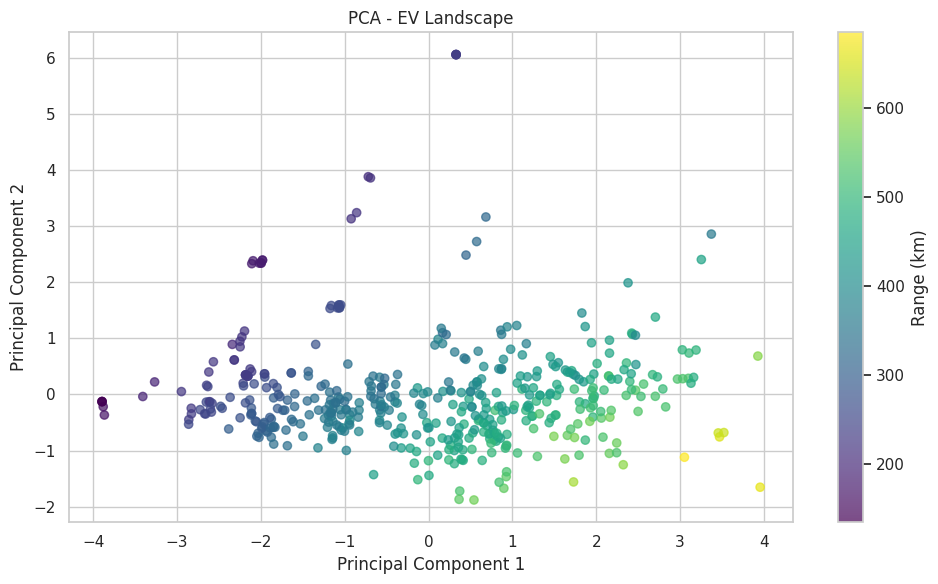

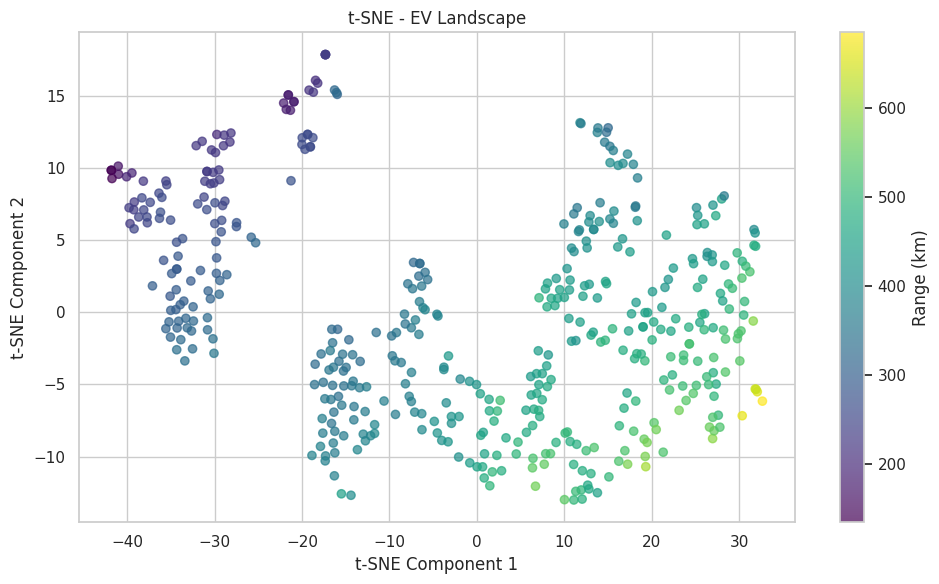

In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Επιλογή χαρακτηριστικών για την ανάλυση
features_for_pca = ['battery_capacity_kWh', 'torque_nm', 'efficiency_wh_per_km', 'range_km']

# Καθαρισμός των δεδομένων για την ανάλυση
df_pca = df[features_for_pca].dropna()

# Standardize τα δεδομένα για PCA ή t-SNE
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_pca_scaled = scaler.fit_transform(df_pca)

# PCA ανάλυση
pca = PCA(n_components=2)
pca_result = pca.fit_transform(df_pca_scaled)

# Εμφάνιση αποτελεσμάτων PCA
plt.figure(figsize=(10, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=df['range_km'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Range (km)')
plt.title('PCA - EV Landscape')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.tight_layout()
plt.show()

# ή

# Ανάλυση με t-SNE
tsne = TSNE(n_components=2, random_state=42)
tsne_result = tsne.fit_transform(df_pca_scaled)

# Εμφάνιση αποτελεσμάτων t-SNE
plt.figure(figsize=(10, 6))
plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=df['range_km'], cmap='viridis', alpha=0.7)
plt.colorbar(label='Range (km)')
plt.title('t-SNE - EV Landscape')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.tight_layout()
plt.show()


In [36]:
print(df.columns)


Index(['brand', 'model', 'top_speed_kmh', 'battery_capacity_kWh',
       'battery_type', 'number_of_cells', 'torque_nm', 'efficiency_wh_per_km',
       'range_km', 'acceleration_0_100_s', 'fast_charging_power_kw_dc',
       'fast_charge_port', 'towing_capacity_kg', 'cargo_volume_l', 'seats',
       'drivetrain', 'segment', 'length_mm', 'width_mm', 'height_mm',
       'car_body_type', 'source_url'],
      dtype='object')


In [38]:
print(df_charging_cleaned.head())  # Έλεγξε τα πρώτα δεδομένα για να δεις τι περιέχουν


   battery_capacity_kWh  fast_charging_power_kw_dc
0                  37.8                       67.0
1                  37.8                       67.0
2                  50.8                       79.0
3                  50.8                       79.0
4                  60.0                       78.0


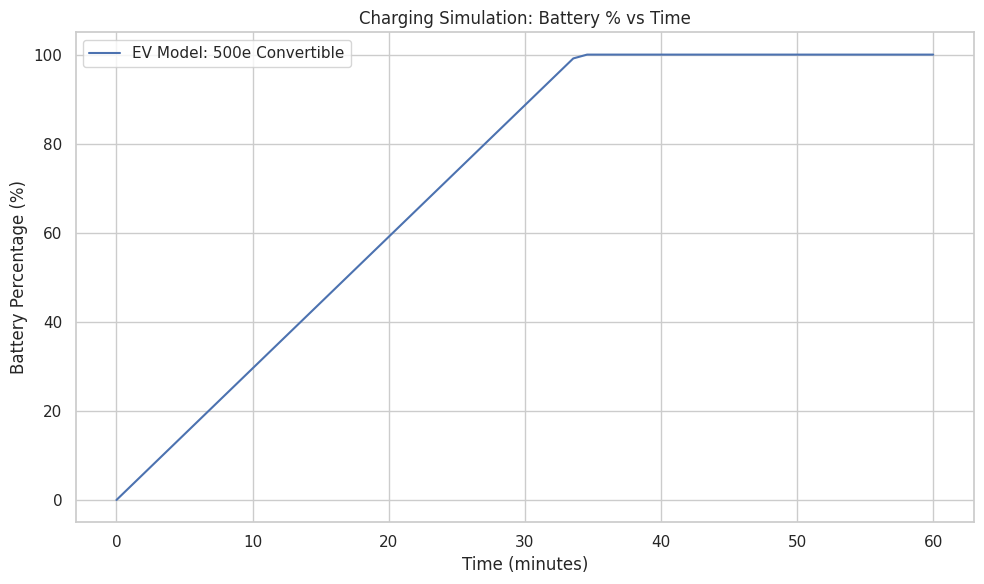

In [39]:
import numpy as np
import matplotlib.pyplot as plt

# Συνάρτηση υπολογισμού φόρτισης
def charging_simulation(row):
    # Βασικά δεδομένα
    battery_capacity = row["battery_capacity_kWh"]
    fast_charging_power = row["fast_charging_power_kw_dc"]
    
    # Υπολογισμός του χρόνου φόρτισης σε λεπτά και ποσοστό φόρτισης
    time = np.linspace(0, 60, 60)  # 60 λεπτά
    charging_percentage = (time / 60) * (fast_charging_power / battery_capacity) * 100
    
    # Περιορίζουμε το ποσοστό φόρτισης στο 100%
    charging_percentage = np.clip(charging_percentage, 0, 100)
    
    return time, charging_percentage

# Επιλέγουμε το πρώτο όχημα ή δείγμα που δεν έχει NaN τιμές
df_charging_cleaned = df.dropna()

if not df_charging_cleaned.empty:
    row = df_charging_cleaned.iloc[0]  # Επιλέγουμε το πρώτο όχημα

    # Δημιουργία του γραφήματος φόρτισης
    time, charging_percentage = charging_simulation(row)
    
    # Δημιουργία του γραφήματος
    plt.figure(figsize=(10, 6))
    plt.plot(time, charging_percentage, label=f'EV Model: {row["model"]}')
    plt.title("Charging Simulation: Battery % vs Time")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Battery Percentage (%)")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
else:
    print("Δεν βρέθηκαν δεδομένα χωρίς NaN τιμές.")


In [41]:
best_efficiency = df.loc[df['efficiency_wh_per_km'].idxmin()]


In [42]:
fastest = df.loc[df['acceleration_0_100_s'].idxmin()]


In [43]:
best_towing = df.loc[df['towing_capacity_kg'].idxmax()]


In [44]:
travel_ready = df.loc[(df['range_km'] >= 400) & (df['fast_charging_power_kw_dc'] >= 100)]


In [45]:
urban_ev = df.loc[(df['length_mm'] < 4000) & (df['efficiency_wh_per_km'] < 150)]


In [51]:
# 1. Οικονομικά αποδοτικό (χαμηλότερη efficiency_wh_per_km)
best_efficiency = df.loc[df['efficiency_wh_per_km'].idxmin()]

# 2. Γρηγορότερο (χαμηλότερη acceleration_0_100_s)
fastest = df.loc[df['acceleration_0_100_s'].idxmin()]

# 3. Ικανό για ρυμούλκηση (μεγαλύτερη towing_capacity_kg)
best_towing = df.loc[df['towing_capacity_kg'].idxmax()]

# 4. Κατάλληλο για ταξίδια (μεγαλύτερο range_km + υψηλή fast_charging_power_kw_dc)
travel_ready = df.loc[(df['range_km'] >= 400) & (df['fast_charging_power_kw_dc'] >= 100)]

# 5. Urban EV (μικρό μέγεθος + καλή κατανάλωση)
urban_ev = df.loc[(df['length_mm'] < 4000) & (df['efficiency_wh_per_km'] < 150)]


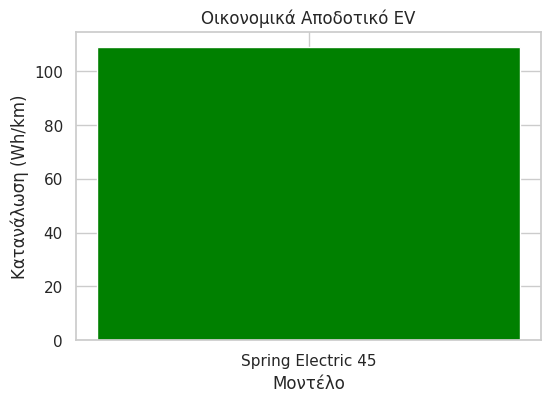

In [52]:
import matplotlib.pyplot as plt

# Οικονομικά αποδοτικό
plt.figure(figsize=(6, 4))
plt.bar(best_efficiency['model'], best_efficiency['efficiency_wh_per_km'], color='green')
plt.title("Οικονομικά Αποδοτικό EV")
plt.xlabel("Μοντέλο")
plt.ylabel("Κατανάλωση (Wh/km)")
plt.show()


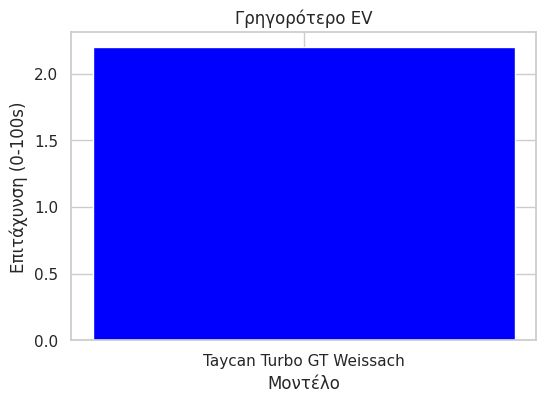

In [53]:
# Γρηγορότερο
plt.figure(figsize=(6, 4))
plt.bar(fastest['model'], fastest['acceleration_0_100_s'], color='blue')
plt.title("Γρηγορότερο EV")
plt.xlabel("Μοντέλο")
plt.ylabel("Επιτάχυνση (0-100s)")
plt.show()


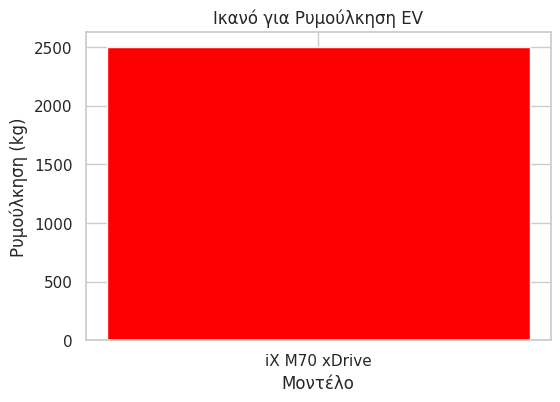

In [54]:
# Ικανό για ρυμούλκηση
plt.figure(figsize=(6, 4))
plt.bar(best_towing['model'], best_towing['towing_capacity_kg'], color='red')
plt.title("Ικανό για Ρυμούλκηση EV")
plt.xlabel("Μοντέλο")
plt.ylabel("Ρυμούλκηση (kg)")
plt.show()


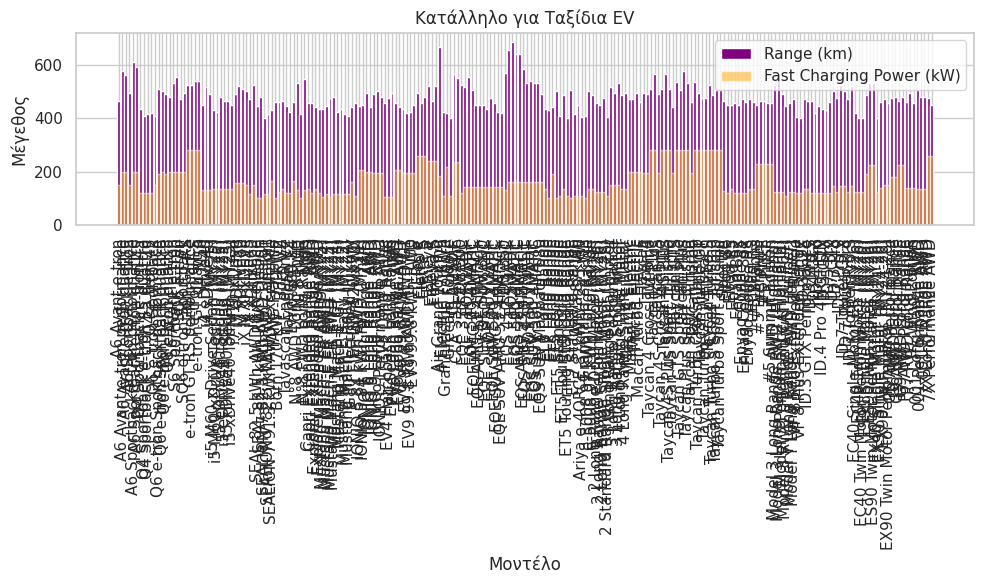

In [55]:
# Κατάλληλο για ταξίδια
travel_ready_models = travel_ready[['model', 'range_km', 'fast_charging_power_kw_dc']]

plt.figure(figsize=(10, 6))
plt.bar(travel_ready_models['model'], travel_ready_models['range_km'], color='purple', label="Range (km)")
plt.bar(travel_ready_models['model'], travel_ready_models['fast_charging_power_kw_dc'], color='orange', alpha=0.5, label="Fast Charging Power (kW)")

plt.title("Κατάλληλο για Ταξίδια EV")
plt.xlabel("Μοντέλο")
plt.ylabel("Μέγεθος")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


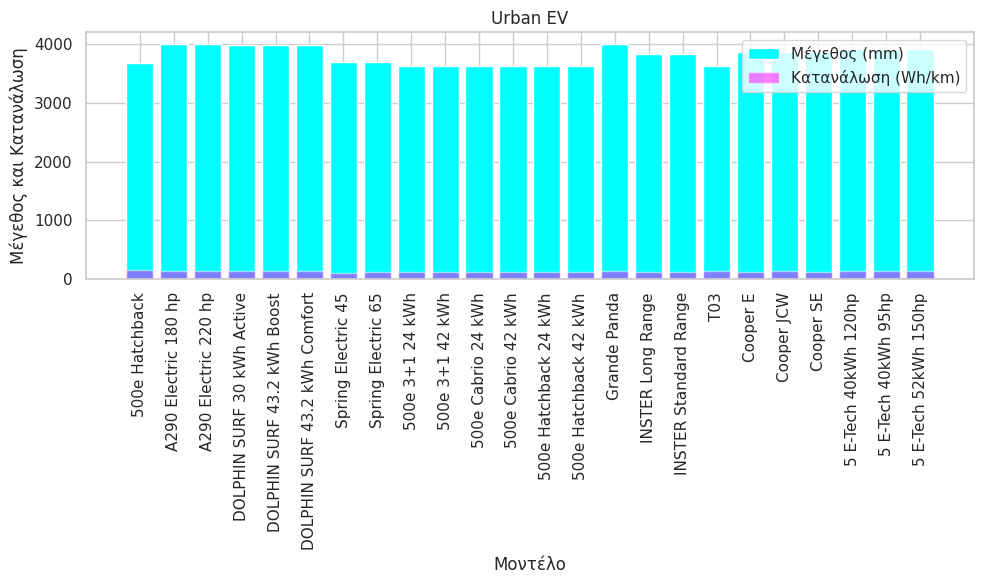

In [56]:
# Urban EV
urban_ev_models = urban_ev[['model', 'length_mm', 'efficiency_wh_per_km']]

plt.figure(figsize=(10, 6))
plt.bar(urban_ev_models['model'], urban_ev_models['length_mm'], color='cyan', label="Μέγεθος (mm)")
plt.bar(urban_ev_models['model'], urban_ev_models['efficiency_wh_per_km'], color='magenta', alpha=0.5, label="Κατανάλωση (Wh/km)")

plt.title("Urban EV")
plt.xlabel("Μοντέλο")
plt.ylabel("Μέγεθος και Κατανάλωση")
plt.xticks(rotation=90)
plt.legend()
plt.tight_layout()
plt.show()


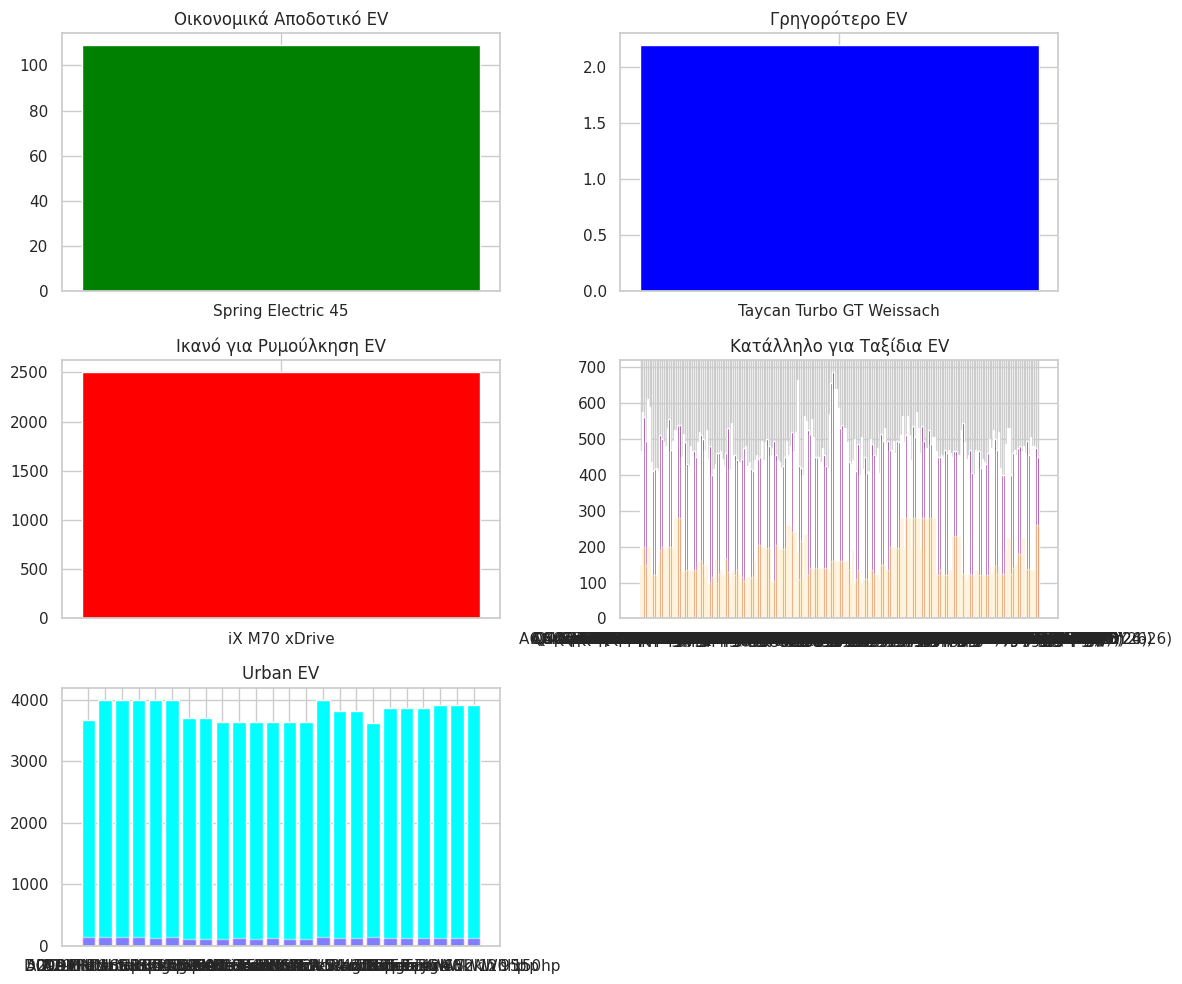

In [57]:
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Οικονομικά αποδοτικό
axes[0, 0].bar(best_efficiency['model'], best_efficiency['efficiency_wh_per_km'], color='green')
axes[0, 0].set_title("Οικονομικά Αποδοτικό EV")

# Γρηγορότερο
axes[0, 1].bar(fastest['model'], fastest['acceleration_0_100_s'], color='blue')
axes[0, 1].set_title("Γρηγορότερο EV")

# Ικανό για ρυμούλκηση
axes[1, 0].bar(best_towing['model'], best_towing['towing_capacity_kg'], color='red')
axes[1, 0].set_title("Ικανό για Ρυμούλκηση EV")

# Κατάλληλο για ταξίδια
axes[1, 1].bar(travel_ready_models['model'], travel_ready_models['range_km'], color='purple', label="Range (km)")
axes[1, 1].bar(travel_ready_models['model'], travel_ready_models['fast_charging_power_kw_dc'], color='orange', alpha=0.5, label="Fast Charging Power (kW)")
axes[1, 1].set_title("Κατάλληλο για Ταξίδια EV")

# Urban EV
axes[2, 0].bar(urban_ev_models['model'], urban_ev_models['length_mm'], color='cyan', label="Μέγεθος (mm)")
axes[2, 0].bar(urban_ev_models['model'], urban_ev_models['efficiency_wh_per_km'], color='magenta', alpha=0.5, label="Κατανάλωση (Wh/km)")
axes[2, 0].set_title("Urban EV")

# Κενό subplot για ευκολία
axes[2, 1].axis('off')

plt.tight_layout()
plt.show()


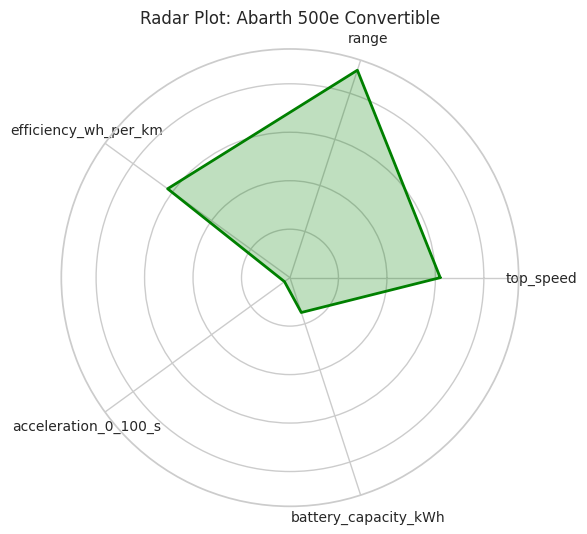

In [46]:
import matplotlib.pyplot as plt
import numpy as np

def radar_plot(row):
    categories = ['top_speed', 'range', 'efficiency_wh_per_km', 'acceleration_0_100_s', 'battery_capacity_kWh']
    values = [row['top_speed_kmh'], row['range_km'], row['efficiency_wh_per_km'], row['acceleration_0_100_s'], row['battery_capacity_kWh']]
    
    # Ορισμός του πλήρους κύκλου για το διάγραμμα
    num_vars = len(categories)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()

    values += values[:1]
    angles += angles[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
    ax.fill(angles, values, color='green', alpha=0.25)
    ax.plot(angles, values, color='green', linewidth=2)

    ax.set_yticklabels([])
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)

    plt.title(f'Radar Plot: {row["brand"]} {row["model"]}')
    plt.tight_layout()
    plt.show()

# Εφαρμογή για το πρώτο δείγμα
radar_plot(df.iloc[0])


In [50]:
import plotly.express as px

fig = px.scatter(df, x="top_speed_kmh", y="range_km", color="brand", size="battery_capacity_kWh", hover_name="model")
fig.update_layout(title="EVs: Top Speed vs Range")
fig.show()


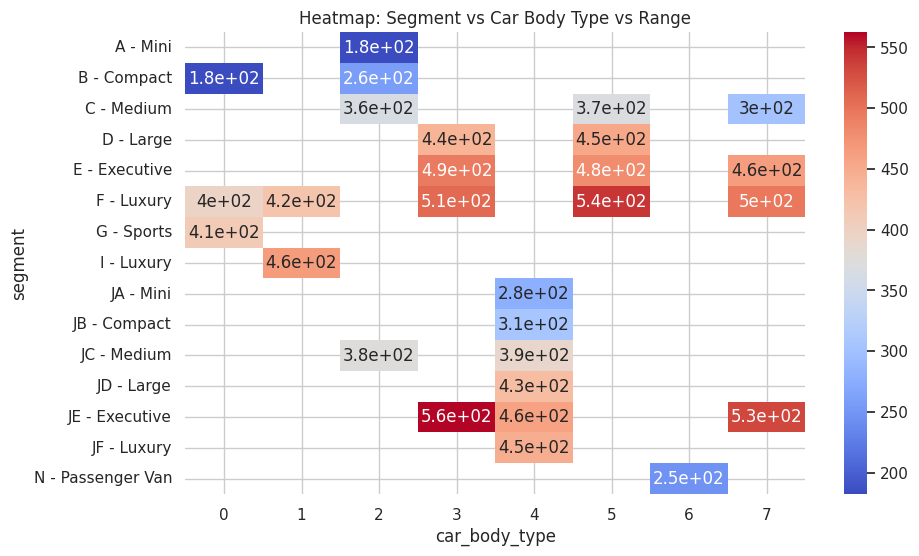

In [49]:
import seaborn as sns

# Δημιουργία heatmap για segment vs car_body_type vs range_km
pivot_table = df.pivot_table(values='range_km', index='segment', columns='car_body_type', aggfunc='mean')
sns.heatmap(pivot_table, annot=True, cmap='coolwarm')
plt.title("Heatmap: Segment vs Car Body Type vs Range")
plt.show()
